In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 连续场景

In [3]:
import numpy as np
import os

file_path = r"E:\Safe-MARL-in-Autonomous-Driving-main\intersection_env_result\exp2\seed_0\crash_record.npy"

# 先检查文件是否存在
if not os.path.exists(file_path):
    print(f"文件不存在: {file_path}")
else:
    # 尝试加载文件
    data = np.load(file_path, allow_pickle=True)
    if data.size == 0:
        print(f"文件为空: {file_path}")
    else:
        print(f"文件非空，包含 {data.size} 个元素")


文件非空，包含 42 个元素


### Intersection原始

episodes is 2798
Leader tail mean/std: (16.14336917562724, 4.225823171903531)
Follower tail mean/std: (15.222222222222221, 4.086967758129935)
Total tail mean/std: (31.365591397849464, 7.477735094350963)
Data length: 2798


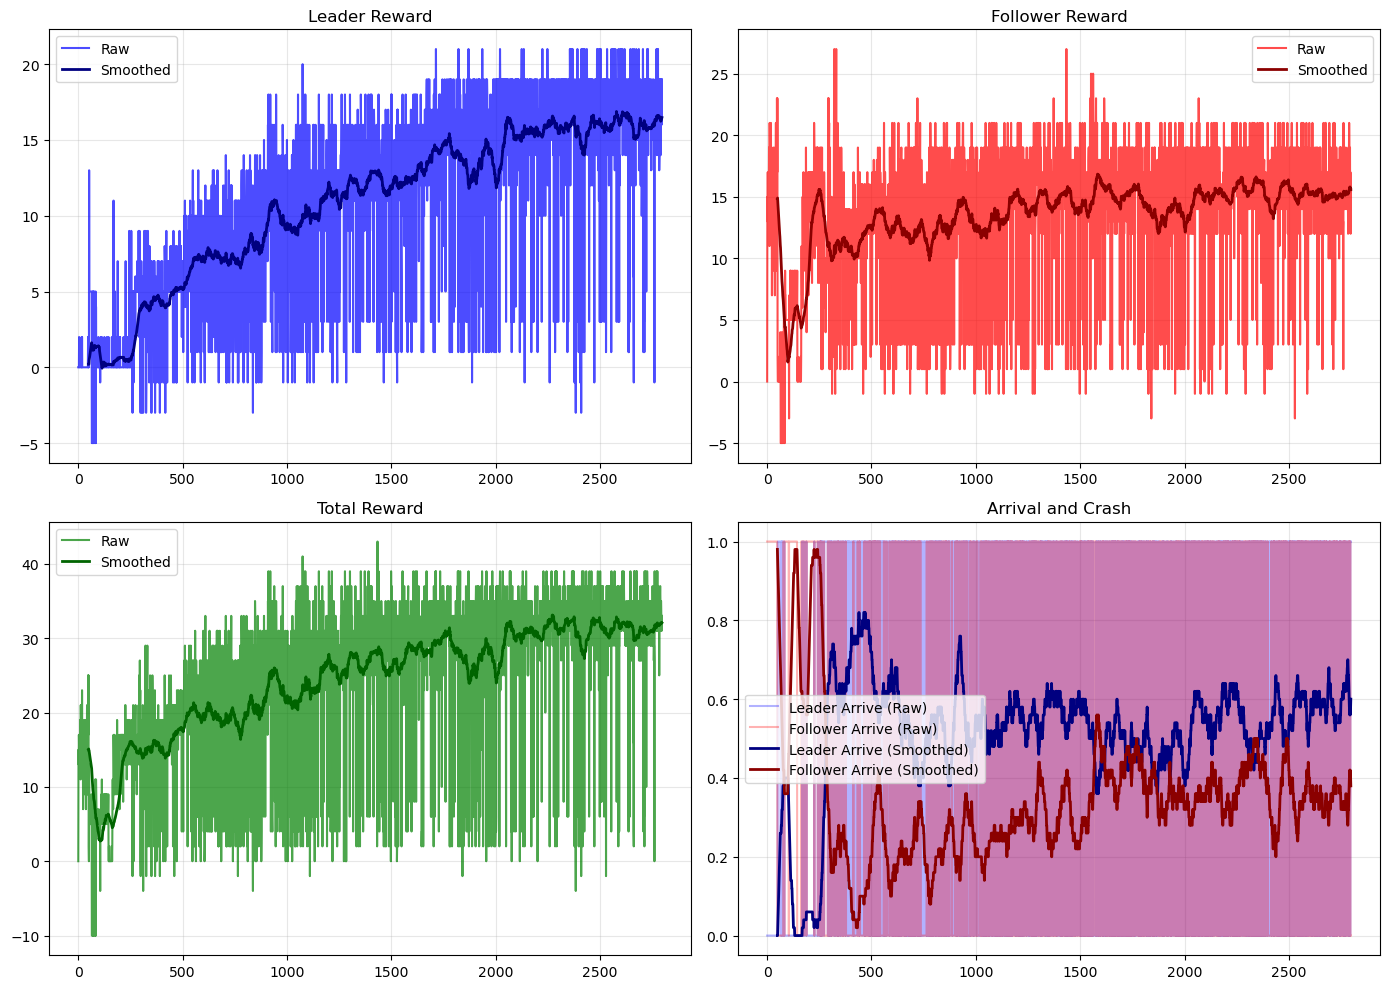

Leader收敛分析: CV=0.027, 改善率=0.017
Follower收敛分析: CV=0.021, 改善率=-0.010


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
file_path_list = ["E:/Safe-MARL-in-Autonomous-Driving-main/intersection_env_result/exp1_bilevel/seed_0"]
window = 50

# Initialize lists
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []

# Check files exist and load
for file_path in file_path_list:
    required_files = ['reward_record.npy','leader_arrive_record.npy','follower_arrive_record.npy','crash_record.npy']
    for fname in required_files:
        full_path = os.path.join(file_path, fname)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
    
    # Load reward
    reward_file = os.path.join(file_path, 'reward_record.npy')
    if os.path.exists(reward_file):
        data = np.load(reward_file, allow_pickle=True)
        if data.size > 0:
            leader_reward_c_bilevel.append(data[0][:3000])
            follower_reward_c_bilevel.append(data[1][:3000])
        else:
            print(f"Warning: reward_record.npy is empty in {file_path}")

    # Load leader/follower arrive
    for arr_name, arr_list in zip(['leader_arrive_record.npy', 'follower_arrive_record.npy'],
                                  [leader_arrive_c_bilevel, follower_arrive_c_bilevel]):
        arr_file = os.path.join(file_path, arr_name)
        if os.path.exists(arr_file):
            arr_data = np.load(arr_file, allow_pickle=True)
            if arr_data.size > 0:
                arr_list.append(arr_data[:3000])
            else:
                print(f"Warning: {arr_name} is empty in {file_path}")

    # Load crash
    crash_file = os.path.join(file_path, 'crash_record.npy')
    if os.path.exists(crash_file):
        crash_data = np.load(crash_file, allow_pickle=True)
        if crash_data.size > 0:
            crash_c_bilevel.append(crash_data[:3000])
        else:
            print(f"Warning: crash_record.npy is empty in {file_path}")

# Check if data loaded
if len(leader_reward_c_bilevel) == 0:
    print("Error: No reward data loaded. Exiting.")
    exit()

# Convert to numpy arrays
leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel) if leader_arrive_c_bilevel else np.array([])
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel) if follower_arrive_c_bilevel else np.array([])
crash_c_bilevel = np.array(crash_c_bilevel) if crash_c_bilevel else np.array([])

# Select first experiment
leader_reward = np.array(leader_reward_c_bilevel[0])
follower_reward = np.array(follower_reward_c_bilevel[0])
leader_arrive = np.array(leader_arrive_c_bilevel[0]) if leader_arrive_c_bilevel.size > 0 else np.array([])
follower_arrive = np.array(follower_arrive_c_bilevel[0]) if follower_arrive_c_bilevel.size > 0 else np.array([])
crash = np.array(crash_c_bilevel[0]) if crash_c_bilevel.size > 0 else np.array([])

# Align lengths
all_arrays = [leader_reward, follower_reward]
if leader_arrive.size>0: all_arrays.append(leader_arrive)
if follower_arrive.size>0: all_arrays.append(follower_arrive)
if crash.size>0: all_arrays.append(crash)
n = min([len(a) for a in all_arrays])
if n == 0:
    print("Error: Data arrays are empty after alignment. Exiting.")
    exit()

leader_reward = leader_reward[:n]
follower_reward = follower_reward[:n]
if leader_arrive.size>0: leader_arrive = leader_arrive[:n]
if follower_arrive.size>0: follower_arrive = follower_arrive[:n]
if crash.size>0: crash = crash[:n]

episodes = np.arange(n)

print(f"episodes is {len(episodes)}")

# Moving average function with auto window
def moving_average(x, w=50):
    if len(x) == 0:
        return np.array([]), np.array([])
    w = min(w, len(x))
    smooth = np.convolve(x, np.ones(w)/w, mode='valid')
    return np.arange(w-1, len(x)), smooth

# Apply smoothing
leader_ep, leader_reward_smooth = moving_average(leader_reward, window)
follower_ep, follower_reward_smooth = moving_average(follower_reward, window)
total_reward = leader_reward + follower_reward
total_ep, total_reward_smooth = moving_average(total_reward, window)
leader_arrive_ep, leader_arrive_smooth = moving_average(leader_arrive, window)
follower_arrive_ep, follower_arrive_smooth = moving_average(follower_arrive, window)
crash_ep, crash_smooth = moving_average(crash, window)

# Tail stats
def tail_stats(x, frac=0.1):
    if len(x)==0: return np.nan, np.nan
    m = max(1, int(len(x) * frac))
    tail = x[-m:]
    return float(np.mean(tail)), float(np.std(tail))

print("Leader tail mean/std:", tail_stats(leader_reward))
print("Follower tail mean/std:", tail_stats(follower_reward))
print("Total tail mean/std:", tail_stats(total_reward))
print("Data length:", n)

# Plotting
fig, axs = plt.subplots(2,2, figsize=(14,10))

# Leader reward
axs[0,0].plot(episodes, leader_reward, color='blue', alpha=0.7, label='Raw', linewidth=1.5)
if len(leader_reward_smooth)>0:
    axs[0,0].plot(leader_ep, leader_reward_smooth, color='navy', label='Smoothed', linewidth=2)
axs[0,0].set_title("Leader Reward")
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# Follower reward
axs[0,1].plot(episodes, follower_reward, color='red', alpha=0.7, label='Raw', linewidth=1.5)
if len(follower_reward_smooth)>0:
    axs[0,1].plot(follower_ep, follower_reward_smooth, color='darkred', label='Smoothed', linewidth=2)
axs[0,1].set_title("Follower Reward")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# Total reward
axs[1,0].plot(episodes, total_reward, color='green', alpha=0.7, label='Raw', linewidth=1.5)
if len(total_reward_smooth)>0:
    axs[1,0].plot(total_ep, total_reward_smooth, color='darkgreen', label='Smoothed', linewidth=2)
axs[1,0].set_title("Total Reward")
axs[1,0].legend()
axs[1,0].grid(alpha=0.3)

# Arrival & Crash
if leader_arrive.size>0: axs[1,1].plot(episodes, leader_arrive, color='blue', alpha=0.3, label='Leader Arrive (Raw)')
if follower_arrive.size>0: axs[1,1].plot(episodes, follower_arrive, color='red', alpha=0.3, label='Follower Arrive (Raw)')
if crash.size>0: axs[1,1].plot(episodes, crash, color='black', alpha=0.3, label='Crash (Raw)')

if len(leader_arrive_smooth)>0: axs[1,1].plot(leader_arrive_ep, leader_arrive_smooth, color='navy', linewidth=2, label='Leader Arrive (Smoothed)')
if len(follower_arrive_smooth)>0: axs[1,1].plot(follower_arrive_ep, follower_arrive_smooth, color='darkred', linewidth=2, label='Follower Arrive (Smoothed)')
if len(crash_smooth)>0: axs[1,1].plot(crash_ep, crash_smooth, color='black', linewidth=2, label='Crash (Smoothed)')

axs[1,1].set_title("Arrival and Crash")
axs[1,1].legend()
axs[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 增加：收敛性分析
def analyze_convergence(rewards, window=100):
    """分析收敛性"""
    recent_10pct = int(len(rewards) * 0.9)
    recent_rewards = rewards[recent_10pct:]
    
    mean_recent = np.mean(recent_rewards)
    std_recent = np.std(recent_rewards)
    cv = std_recent / mean_recent if mean_recent > 0 else float('inf')
    
    # 与前一段对比
    prev_rewards = rewards[recent_10pct-window:recent_10pct]
    mean_prev = np.mean(prev_rewards)
    improvement = (mean_recent - mean_prev) / abs(mean_prev) if mean_prev != 0 else 0
    
    return {
        'mean': mean_recent,
        'std': std_recent,
        'cv': cv,
        'improvement': improvement,
        'converged': cv < 0.1 and abs(improvement) < 0.05
    }

# 应用分析
leader_stats = analyze_convergence(leader_reward_smooth)
follower_stats = analyze_convergence(follower_reward_smooth)

print(f"Leader收敛分析: CV={leader_stats['cv']:.3f}, 改善率={leader_stats['improvement']:.3f}")
print(f"Follower收敛分析: CV={follower_stats['cv']:.3f}, 改善率={follower_stats['improvement']:.3f}")

### Intersection1(exp4)(time_steps=100000, max_episode_len=600)

episodes is 863
Leader tail mean/std: (4.267441860465116, 5.390397186480339)
Follower tail mean/std: (11.046511627906977, 6.183073249445159)
Total tail mean/std: (15.313953488372093, 9.462608947370695)
Data length: 863


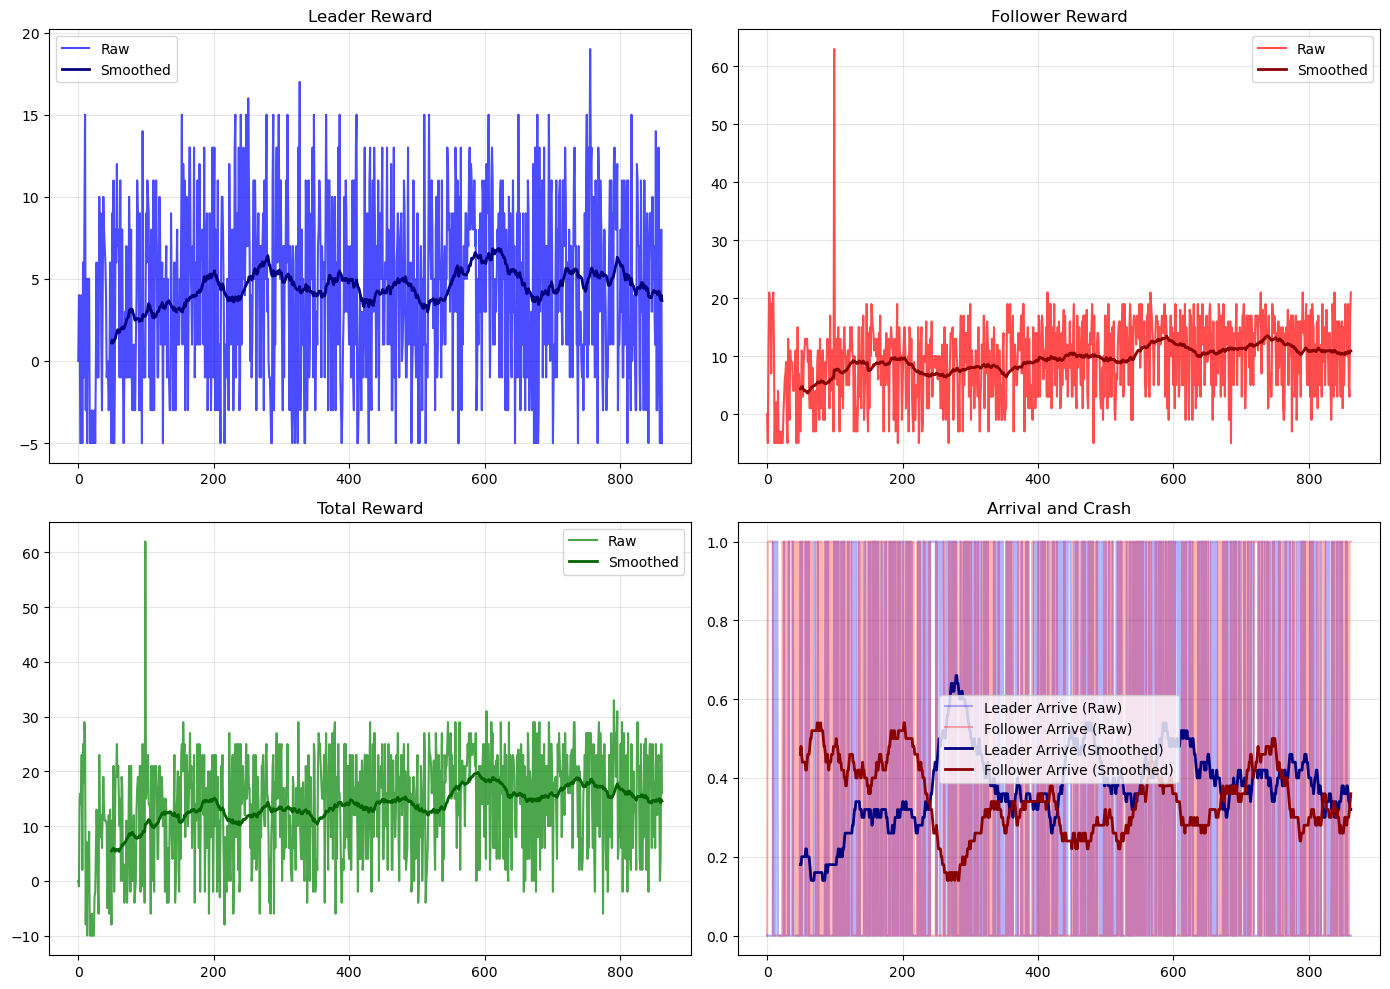

Leader收敛分析: CV=0.138, 改善率=-0.031
Follower收敛分析: CV=0.025, 改善率=-0.105


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
file_path_list = ["E:/Safe-MARL-in-Autonomous-Driving-main/intersection_env_result/exp4(降噪_1w)/seed_0/"]
window = 50

# Initialize lists
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []

# Check files exist and load
for file_path in file_path_list:
    required_files = ['reward_record.npy','leader_arrive_record.npy','follower_arrive_record.npy','crash_record.npy']
    for fname in required_files:
        full_path = os.path.join(file_path, fname)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
    
    # Load reward
    reward_file = os.path.join(file_path, 'reward_record.npy')
    if os.path.exists(reward_file):
        data = np.load(reward_file, allow_pickle=True)
        if data.size > 0:
            leader_reward_c_bilevel.append(data[0][:3000])
            follower_reward_c_bilevel.append(data[1][:3000])
        else:
            print(f"Warning: reward_record.npy is empty in {file_path}")

    # Load leader/follower arrive
    for arr_name, arr_list in zip(['leader_arrive_record.npy', 'follower_arrive_record.npy'],
                                  [leader_arrive_c_bilevel, follower_arrive_c_bilevel]):
        arr_file = os.path.join(file_path, arr_name)
        if os.path.exists(arr_file):
            arr_data = np.load(arr_file, allow_pickle=True)
            if arr_data.size > 0:
                arr_list.append(arr_data[:3000])
            else:
                print(f"Warning: {arr_name} is empty in {file_path}")

    # Load crash
    crash_file = os.path.join(file_path, 'crash_record.npy')
    if os.path.exists(crash_file):
        crash_data = np.load(crash_file, allow_pickle=True)
        if crash_data.size > 0:
            crash_c_bilevel.append(crash_data[:3000])
        else:
            print(f"Warning: crash_record.npy is empty in {file_path}")

# Check if data loaded
if len(leader_reward_c_bilevel) == 0:
    print("Error: No reward data loaded. Exiting.")
    exit()

# Convert to numpy arrays
leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel) if leader_arrive_c_bilevel else np.array([])
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel) if follower_arrive_c_bilevel else np.array([])
crash_c_bilevel = np.array(crash_c_bilevel) if crash_c_bilevel else np.array([])

# Select first experiment
leader_reward = np.array(leader_reward_c_bilevel[0])
follower_reward = np.array(follower_reward_c_bilevel[0])
leader_arrive = np.array(leader_arrive_c_bilevel[0]) if leader_arrive_c_bilevel.size > 0 else np.array([])
follower_arrive = np.array(follower_arrive_c_bilevel[0]) if follower_arrive_c_bilevel.size > 0 else np.array([])
crash = np.array(crash_c_bilevel[0]) if crash_c_bilevel.size > 0 else np.array([])

# Align lengths
all_arrays = [leader_reward, follower_reward]
if leader_arrive.size>0: all_arrays.append(leader_arrive)
if follower_arrive.size>0: all_arrays.append(follower_arrive)
if crash.size>0: all_arrays.append(crash)
n = min([len(a) for a in all_arrays])
if n == 0:
    print("Error: Data arrays are empty after alignment. Exiting.")
    exit()

leader_reward = leader_reward[:n]
follower_reward = follower_reward[:n]
if leader_arrive.size>0: leader_arrive = leader_arrive[:n]
if follower_arrive.size>0: follower_arrive = follower_arrive[:n]
if crash.size>0: crash = crash[:n]

episodes = np.arange(n)

print(f"episodes is {len(episodes)}")

# Moving average function with auto window
def moving_average(x, w=50):
    if len(x) == 0:
        return np.array([]), np.array([])
    w = min(w, len(x))
    smooth = np.convolve(x, np.ones(w)/w, mode='valid')
    return np.arange(w-1, len(x)), smooth

# Apply smoothing
leader_ep, leader_reward_smooth = moving_average(leader_reward, window)
follower_ep, follower_reward_smooth = moving_average(follower_reward, window)
total_reward = leader_reward + follower_reward
total_ep, total_reward_smooth = moving_average(total_reward, window)
leader_arrive_ep, leader_arrive_smooth = moving_average(leader_arrive, window)
follower_arrive_ep, follower_arrive_smooth = moving_average(follower_arrive, window)
crash_ep, crash_smooth = moving_average(crash, window)

# Tail stats
def tail_stats(x, frac=0.1):
    if len(x)==0: return np.nan, np.nan
    m = max(1, int(len(x) * frac))
    tail = x[-m:]
    return float(np.mean(tail)), float(np.std(tail))

print("Leader tail mean/std:", tail_stats(leader_reward))
print("Follower tail mean/std:", tail_stats(follower_reward))
print("Total tail mean/std:", tail_stats(total_reward))
print("Data length:", n)

# Plotting
fig, axs = plt.subplots(2,2, figsize=(14,10))

# Leader reward
axs[0,0].plot(episodes, leader_reward, color='blue', alpha=0.7, label='Raw', linewidth=1.5)
if len(leader_reward_smooth)>0:
    axs[0,0].plot(leader_ep, leader_reward_smooth, color='navy', label='Smoothed', linewidth=2)
axs[0,0].set_title("Leader Reward")
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# Follower reward
axs[0,1].plot(episodes, follower_reward, color='red', alpha=0.7, label='Raw', linewidth=1.5)
if len(follower_reward_smooth)>0:
    axs[0,1].plot(follower_ep, follower_reward_smooth, color='darkred', label='Smoothed', linewidth=2)
axs[0,1].set_title("Follower Reward")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# Total reward
axs[1,0].plot(episodes, total_reward, color='green', alpha=0.7, label='Raw', linewidth=1.5)
if len(total_reward_smooth)>0:
    axs[1,0].plot(total_ep, total_reward_smooth, color='darkgreen', label='Smoothed', linewidth=2)
axs[1,0].set_title("Total Reward")
axs[1,0].legend()
axs[1,0].grid(alpha=0.3)

# Arrival & Crash
if leader_arrive.size>0: axs[1,1].plot(episodes, leader_arrive, color='blue', alpha=0.3, label='Leader Arrive (Raw)')
if follower_arrive.size>0: axs[1,1].plot(episodes, follower_arrive, color='red', alpha=0.3, label='Follower Arrive (Raw)')
if crash.size>0: axs[1,1].plot(episodes, crash, color='black', alpha=0.3, label='Crash (Raw)')

if len(leader_arrive_smooth)>0: axs[1,1].plot(leader_arrive_ep, leader_arrive_smooth, color='navy', linewidth=2, label='Leader Arrive (Smoothed)')
if len(follower_arrive_smooth)>0: axs[1,1].plot(follower_arrive_ep, follower_arrive_smooth, color='darkred', linewidth=2, label='Follower Arrive (Smoothed)')
if len(crash_smooth)>0: axs[1,1].plot(crash_ep, crash_smooth, color='black', linewidth=2, label='Crash (Smoothed)')

axs[1,1].set_title("Arrival and Crash")
axs[1,1].legend()
axs[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 增加：收敛性分析
def analyze_convergence(rewards, window=100):
    """分析收敛性"""
    recent_10pct = int(len(rewards) * 0.9)
    recent_rewards = rewards[recent_10pct:]
    
    mean_recent = np.mean(recent_rewards)
    std_recent = np.std(recent_rewards)
    cv = std_recent / mean_recent if mean_recent > 0 else float('inf')
    
    # 与前一段对比
    prev_rewards = rewards[recent_10pct-window:recent_10pct]
    mean_prev = np.mean(prev_rewards)
    improvement = (mean_recent - mean_prev) / abs(mean_prev) if mean_prev != 0 else 0
    
    return {
        'mean': mean_recent,
        'std': std_recent,
        'cv': cv,
        'improvement': improvement,
        'converged': cv < 0.1 and abs(improvement) < 0.05
    }

# 应用分析
leader_stats = analyze_convergence(leader_reward_smooth)
follower_stats = analyze_convergence(follower_reward_smooth)

print(f"Leader收敛分析: CV={leader_stats['cv']:.3f}, 改善率={leader_stats['improvement']:.3f}")
print(f"Follower收敛分析: CV={follower_stats['cv']:.3f}, 改善率={follower_stats['improvement']:.3f}")

episodes is 121
Leader tail mean/std: (6.25, 5.959935681979575)
Follower tail mean/std: (11.166666666666666, 5.413460589637238)
Total tail mean/std: (17.416666666666668, 7.02920494951045)
Data length: 121


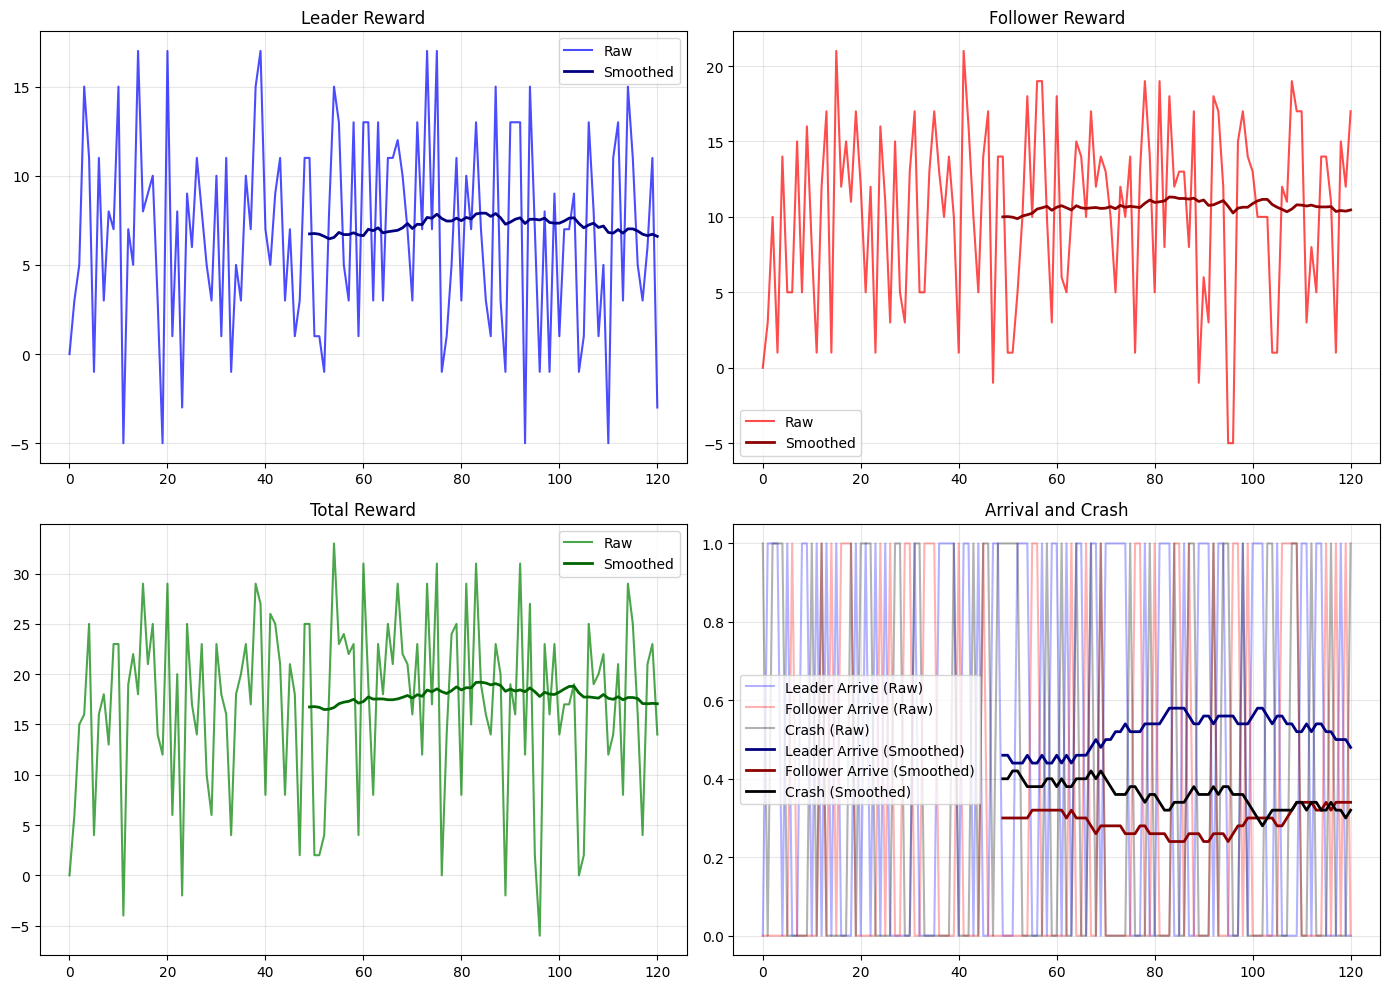

Leader收敛分析: CV=0.022, 改善率=-0.081
Follower收敛分析: CV=0.013, 改善率=-0.028


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
file_path_list = ["C:/Users/10733/Desktop/safe/safe/intersection_env_result/exp4(1w)/seed_0"]
window = 50

# Initialize lists
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []

# Check files exist and load
for file_path in file_path_list:
    required_files = ['reward_record.npy','leader_arrive_record.npy','follower_arrive_record.npy','crash_record.npy']
    for fname in required_files:
        full_path = os.path.join(file_path, fname)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")

    # Load reward
    reward_file = os.path.join(file_path, 'reward_record.npy')
    if os.path.exists(reward_file):
        data = np.load(reward_file, allow_pickle=True)
        if data.size > 0:
            leader_reward_c_bilevel.append(data[0][:3000])
            follower_reward_c_bilevel.append(data[1][:3000])
        else:
            print(f"Warning: reward_record.npy is empty in {file_path}")

    # Load leader/follower arrive
    for arr_name, arr_list in zip(['leader_arrive_record.npy', 'follower_arrive_record.npy'],
                                  [leader_arrive_c_bilevel, follower_arrive_c_bilevel]):
        arr_file = os.path.join(file_path, arr_name)
        if os.path.exists(arr_file):
            arr_data = np.load(arr_file, allow_pickle=True)
            if arr_data.size > 0:
                arr_list.append(arr_data[:3000])
            else:
                print(f"Warning: {arr_name} is empty in {file_path}")

    # Load crash
    crash_file = os.path.join(file_path, 'crash_record.npy')
    if os.path.exists(crash_file):
        crash_data = np.load(crash_file, allow_pickle=True)
        if crash_data.size > 0:
            crash_c_bilevel.append(crash_data[:3000])
        else:
            print(f"Warning: crash_record.npy is empty in {file_path}")

# Check if data loaded
if len(leader_reward_c_bilevel) == 0:
    print("Error: No reward data loaded. Exiting.")
    exit()

# Convert to numpy arrays
leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel) if leader_arrive_c_bilevel else np.array([])
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel) if follower_arrive_c_bilevel else np.array([])
crash_c_bilevel = np.array(crash_c_bilevel) if crash_c_bilevel else np.array([])

# Select first experiment
leader_reward = np.array(leader_reward_c_bilevel[0])
follower_reward = np.array(follower_reward_c_bilevel[0])
leader_arrive = np.array(leader_arrive_c_bilevel[0]) if leader_arrive_c_bilevel.size > 0 else np.array([])
follower_arrive = np.array(follower_arrive_c_bilevel[0]) if follower_arrive_c_bilevel.size > 0 else np.array([])
crash = np.array(crash_c_bilevel[0]) if crash_c_bilevel.size > 0 else np.array([])

# Align lengths
all_arrays = [leader_reward, follower_reward]
if leader_arrive.size>0: all_arrays.append(leader_arrive)
if follower_arrive.size>0: all_arrays.append(follower_arrive)
if crash.size>0: all_arrays.append(crash)
n = min([len(a) for a in all_arrays])
if n == 0:
    print("Error: Data arrays are empty after alignment. Exiting.")
    exit()

leader_reward = leader_reward[:n]
follower_reward = follower_reward[:n]
if leader_arrive.size>0: leader_arrive = leader_arrive[:n]
if follower_arrive.size>0: follower_arrive = follower_arrive[:n]
if crash.size>0: crash = crash[:n]

episodes = np.arange(n)

print(f"episodes is {len(episodes)}")

# Moving average function with auto window
def moving_average(x, w=50):
    if len(x) == 0:
        return np.array([]), np.array([])
    w = min(w, len(x))
    smooth = np.convolve(x, np.ones(w)/w, mode='valid')
    return np.arange(w-1, len(x)), smooth

# Apply smoothing
leader_ep, leader_reward_smooth = moving_average(leader_reward, window)
follower_ep, follower_reward_smooth = moving_average(follower_reward, window)
total_reward = leader_reward + follower_reward
total_ep, total_reward_smooth = moving_average(total_reward, window)
leader_arrive_ep, leader_arrive_smooth = moving_average(leader_arrive, window)
follower_arrive_ep, follower_arrive_smooth = moving_average(follower_arrive, window)
crash_ep, crash_smooth = moving_average(crash, window)

# Tail stats
def tail_stats(x, frac=0.1):
    if len(x)==0: return np.nan, np.nan
    m = max(1, int(len(x) * frac))
    tail = x[-m:]
    return float(np.mean(tail)), float(np.std(tail))

print("Leader tail mean/std:", tail_stats(leader_reward))
print("Follower tail mean/std:", tail_stats(follower_reward))
print("Total tail mean/std:", tail_stats(total_reward))
print("Data length:", n)

# Plotting
fig, axs = plt.subplots(2,2, figsize=(14,10))

# Leader reward
axs[0,0].plot(episodes, leader_reward, color='blue', alpha=0.7, label='Raw', linewidth=1.5)
if len(leader_reward_smooth)>0:
    axs[0,0].plot(leader_ep, leader_reward_smooth, color='navy', label='Smoothed', linewidth=2)
axs[0,0].set_title("Leader Reward")
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# Follower reward
axs[0,1].plot(episodes, follower_reward, color='red', alpha=0.7, label='Raw', linewidth=1.5)
if len(follower_reward_smooth)>0:
    axs[0,1].plot(follower_ep, follower_reward_smooth, color='darkred', label='Smoothed', linewidth=2)
axs[0,1].set_title("Follower Reward")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# Total reward
axs[1,0].plot(episodes, total_reward, color='green', alpha=0.7, label='Raw', linewidth=1.5)
if len(total_reward_smooth)>0:
    axs[1,0].plot(total_ep, total_reward_smooth, color='darkgreen', label='Smoothed', linewidth=2)
axs[1,0].set_title("Total Reward")
axs[1,0].legend()
axs[1,0].grid(alpha=0.3)

# Arrival & Crash
if leader_arrive.size>0: axs[1,1].plot(episodes, leader_arrive, color='blue', alpha=0.3, label='Leader Arrive (Raw)')
if follower_arrive.size>0: axs[1,1].plot(episodes, follower_arrive, color='red', alpha=0.3, label='Follower Arrive (Raw)')
if crash.size>0: axs[1,1].plot(episodes, crash, color='black', alpha=0.3, label='Crash (Raw)')

if len(leader_arrive_smooth)>0: axs[1,1].plot(leader_arrive_ep, leader_arrive_smooth, color='navy', linewidth=2, label='Leader Arrive (Smoothed)')
if len(follower_arrive_smooth)>0: axs[1,1].plot(follower_arrive_ep, follower_arrive_smooth, color='darkred', linewidth=2, label='Follower Arrive (Smoothed)')
if len(crash_smooth)>0: axs[1,1].plot(crash_ep, crash_smooth, color='black', linewidth=2, label='Crash (Smoothed)')

axs[1,1].set_title("Arrival and Crash")
axs[1,1].legend()
axs[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 增加：收敛性分析
def analyze_convergence(rewards, window=100):
    """分析收敛性"""
    recent_10pct = int(len(rewards) * 0.9)
    recent_rewards = rewards[recent_10pct:]

    mean_recent = np.mean(recent_rewards)
    std_recent = np.std(recent_rewards)
    cv = std_recent / mean_recent if mean_recent > 0 else float('inf')

    # 与前一段对比
    prev_rewards = rewards[recent_10pct-window:recent_10pct]
    mean_prev = np.mean(prev_rewards)
    improvement = (mean_recent - mean_prev) / abs(mean_prev) if mean_prev != 0 else 0

    return {
        'mean': mean_recent,
        'std': std_recent,
        'cv': cv,
        'improvement': improvement,
        'converged': cv < 0.1 and abs(improvement) < 0.05
    }

# 应用分析
leader_stats = analyze_convergence(leader_reward_smooth)
follower_stats = analyze_convergence(follower_reward_smooth)

print(f"Leader收敛分析: CV={leader_stats['cv']:.3f}, 改善率={leader_stats['improvement']:.3f}")
print(f"Follower收敛分析: CV={follower_stats['cv']:.3f}, 改善率={follower_stats['improvement']:.3f}")

### Intersection2(exp2)(time_steps=10000, max_episode_len=400)

episodes is 42
Leader tail mean/std: (79.5, 69.53596191899555)
Follower tail mean/std: (-1.25, 2.165063509461097)
Total tail mean/std: (78.25, 68.29119635794939)
Data length: 42


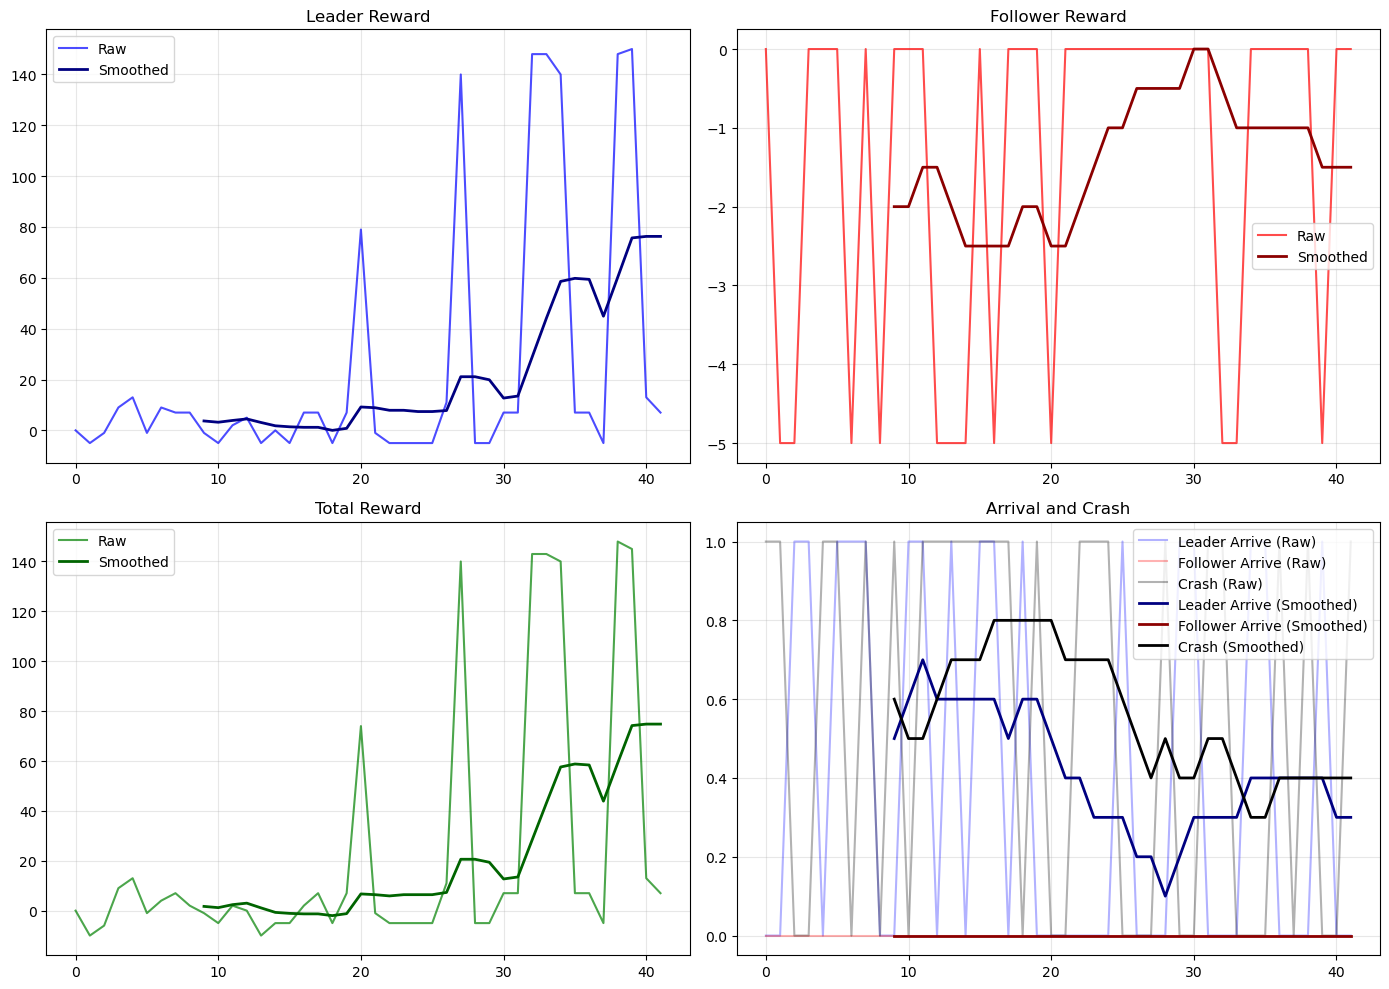

Leader收敛分析: CV=0.096, 改善率=3.496
Follower收敛分析: CV=inf, 改善率=0.027


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
file_path_list = ["E:/Safe-MARL-in-Autonomous-Driving-main/intersection_env_result/exp2/seed_0"]
window = 10

# Initialize lists
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []

# Check files exist and load
for file_path in file_path_list:
    required_files = ['reward_record.npy','leader_arrive_record.npy','follower_arrive_record.npy','crash_record.npy']
    for fname in required_files:
        full_path = os.path.join(file_path, fname)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
    
    # Load reward
    reward_file = os.path.join(file_path, 'reward_record.npy')
    if os.path.exists(reward_file):
        data = np.load(reward_file, allow_pickle=True)
        if data.size > 0:
            leader_reward_c_bilevel.append(data[0][:30000])
            follower_reward_c_bilevel.append(data[1][:30000])
        else:
            print(f"Warning: reward_record.npy is empty in {file_path}")

    # Load leader/follower arrive
    for arr_name, arr_list in zip(['leader_arrive_record.npy', 'follower_arrive_record.npy'],
                                  [leader_arrive_c_bilevel, follower_arrive_c_bilevel]):
        arr_file = os.path.join(file_path, arr_name)
        if os.path.exists(arr_file):
            arr_data = np.load(arr_file, allow_pickle=True)
            if arr_data.size > 0:
                arr_list.append(arr_data[:30000])
            else:
                print(f"Warning: {arr_name} is empty in {file_path}")

    # Load crash
    crash_file = os.path.join(file_path, 'crash_record.npy')
    if os.path.exists(crash_file):
        crash_data = np.load(crash_file, allow_pickle=True)
        if crash_data.size > 0:
            crash_c_bilevel.append(crash_data[:30000])
        else:
            print(f"Warning: crash_record.npy is empty in {file_path}")

# Check if data loaded
if len(leader_reward_c_bilevel) == 0:
    print("Error: No reward data loaded. Exiting.")
    exit()

# Convert to numpy arrays
leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel) if leader_arrive_c_bilevel else np.array([])
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel) if follower_arrive_c_bilevel else np.array([])
crash_c_bilevel = np.array(crash_c_bilevel) if crash_c_bilevel else np.array([])

# Select first experiment
leader_reward = np.array(leader_reward_c_bilevel[0])
follower_reward = np.array(follower_reward_c_bilevel[0])
leader_arrive = np.array(leader_arrive_c_bilevel[0]) if leader_arrive_c_bilevel.size > 0 else np.array([])
follower_arrive = np.array(follower_arrive_c_bilevel[0]) if follower_arrive_c_bilevel.size > 0 else np.array([])
crash = np.array(crash_c_bilevel[0]) if crash_c_bilevel.size > 0 else np.array([])

# Align lengths
all_arrays = [leader_reward, follower_reward]
if leader_arrive.size>0: all_arrays.append(leader_arrive)
if follower_arrive.size>0: all_arrays.append(follower_arrive)
if crash.size>0: all_arrays.append(crash)
n = min([len(a) for a in all_arrays])
if n == 0:
    print("Error: Data arrays are empty after alignment. Exiting.")
    exit()

leader_reward = leader_reward[:n]
follower_reward = follower_reward[:n]
if leader_arrive.size>0: leader_arrive = leader_arrive[:n]
if follower_arrive.size>0: follower_arrive = follower_arrive[:n]
if crash.size>0: crash = crash[:n]

episodes = np.arange(n)

print(f"episodes is {len(episodes)}")

# Moving average function with auto window
def moving_average(x, w=50):
    if len(x) == 0:
        return np.array([]), np.array([])
    w = min(w, len(x))
    smooth = np.convolve(x, np.ones(w)/w, mode='valid')
    return np.arange(w-1, len(x)), smooth

# Apply smoothing
leader_ep, leader_reward_smooth = moving_average(leader_reward, window)
follower_ep, follower_reward_smooth = moving_average(follower_reward, window)
total_reward = leader_reward + follower_reward
total_ep, total_reward_smooth = moving_average(total_reward, window)
leader_arrive_ep, leader_arrive_smooth = moving_average(leader_arrive, window)
follower_arrive_ep, follower_arrive_smooth = moving_average(follower_arrive, window)
crash_ep, crash_smooth = moving_average(crash, window)

# Tail stats
def tail_stats(x, frac=0.1):
    if len(x)==0: return np.nan, np.nan
    m = max(1, int(len(x) * frac))
    tail = x[-m:]
    return float(np.mean(tail)), float(np.std(tail))

print("Leader tail mean/std:", tail_stats(leader_reward))
print("Follower tail mean/std:", tail_stats(follower_reward))
print("Total tail mean/std:", tail_stats(total_reward))
print("Data length:", n)

# Plotting
fig, axs = plt.subplots(2,2, figsize=(14,10))

# Leader reward
axs[0,0].plot(episodes, leader_reward, color='blue', alpha=0.7, label='Raw', linewidth=1.5)
if len(leader_reward_smooth)>0:
    axs[0,0].plot(leader_ep, leader_reward_smooth, color='navy', label='Smoothed', linewidth=2)
axs[0,0].set_title("Leader Reward")
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# Follower reward
axs[0,1].plot(episodes, follower_reward, color='red', alpha=0.7, label='Raw', linewidth=1.5)
if len(follower_reward_smooth)>0:
    axs[0,1].plot(follower_ep, follower_reward_smooth, color='darkred', label='Smoothed', linewidth=2)
axs[0,1].set_title("Follower Reward")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# Total reward
axs[1,0].plot(episodes, total_reward, color='green', alpha=0.7, label='Raw', linewidth=1.5)
if len(total_reward_smooth)>0:
    axs[1,0].plot(total_ep, total_reward_smooth, color='darkgreen', label='Smoothed', linewidth=2)
axs[1,0].set_title("Total Reward")
axs[1,0].legend()
axs[1,0].grid(alpha=0.3)

# Arrival & Crash
if leader_arrive.size>0: axs[1,1].plot(episodes, leader_arrive, color='blue', alpha=0.3, label='Leader Arrive (Raw)')
if follower_arrive.size>0: axs[1,1].plot(episodes, follower_arrive, color='red', alpha=0.3, label='Follower Arrive (Raw)')
if crash.size>0: axs[1,1].plot(episodes, crash, color='black', alpha=0.3, label='Crash (Raw)')

if len(leader_arrive_smooth)>0: axs[1,1].plot(leader_arrive_ep, leader_arrive_smooth, color='navy', linewidth=2, label='Leader Arrive (Smoothed)')
if len(follower_arrive_smooth)>0: axs[1,1].plot(follower_arrive_ep, follower_arrive_smooth, color='darkred', linewidth=2, label='Follower Arrive (Smoothed)')
if len(crash_smooth)>0: axs[1,1].plot(crash_ep, crash_smooth, color='black', linewidth=2, label='Crash (Smoothed)')

axs[1,1].set_title("Arrival and Crash")
axs[1,1].legend()
axs[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 增加：收敛性分析
def analyze_convergence(rewards, window=100):
    """分析收敛性"""
    recent_10pct = int(len(rewards) * 0.9)
    recent_rewards = rewards[recent_10pct:]
    
    mean_recent = np.mean(recent_rewards)
    std_recent = np.std(recent_rewards)
    cv = std_recent / mean_recent if mean_recent > 0 else float('inf')
    
    # 与前一段对比
    prev_rewards = rewards[recent_10pct-window:recent_10pct]
    mean_prev = np.mean(prev_rewards)
    improvement = (mean_recent - mean_prev) / abs(mean_prev) if mean_prev != 0 else 0
    
    return {
        'mean': mean_recent,
        'std': std_recent,
        'cv': cv,
        'improvement': improvement,
        'converged': cv < 0.1 and abs(improvement) < 0.05
    }

# 应用分析
leader_stats = analyze_convergence(leader_reward_smooth)
follower_stats = analyze_convergence(follower_reward_smooth)

print(f"Leader收敛分析: CV={leader_stats['cv']:.3f}, 改善率={leader_stats['improvement']:.3f}")
print(f"Follower收敛分析: CV={follower_stats['cv']:.3f}, 改善率={follower_stats['improvement']:.3f}")

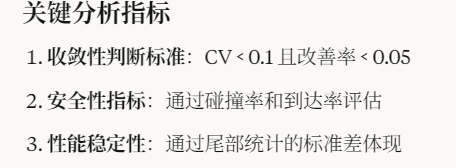

### Intersection3(exp3)(time_steps=10000, max_episode_len=300)

episodes is 256
Leader tail mean/std: (2.36, 4.058374058659452)
Follower tail mean/std: (8.12, 12.558089026599548)
Total tail mean/std: (10.48, 14.366962100597327)
Data length: 256


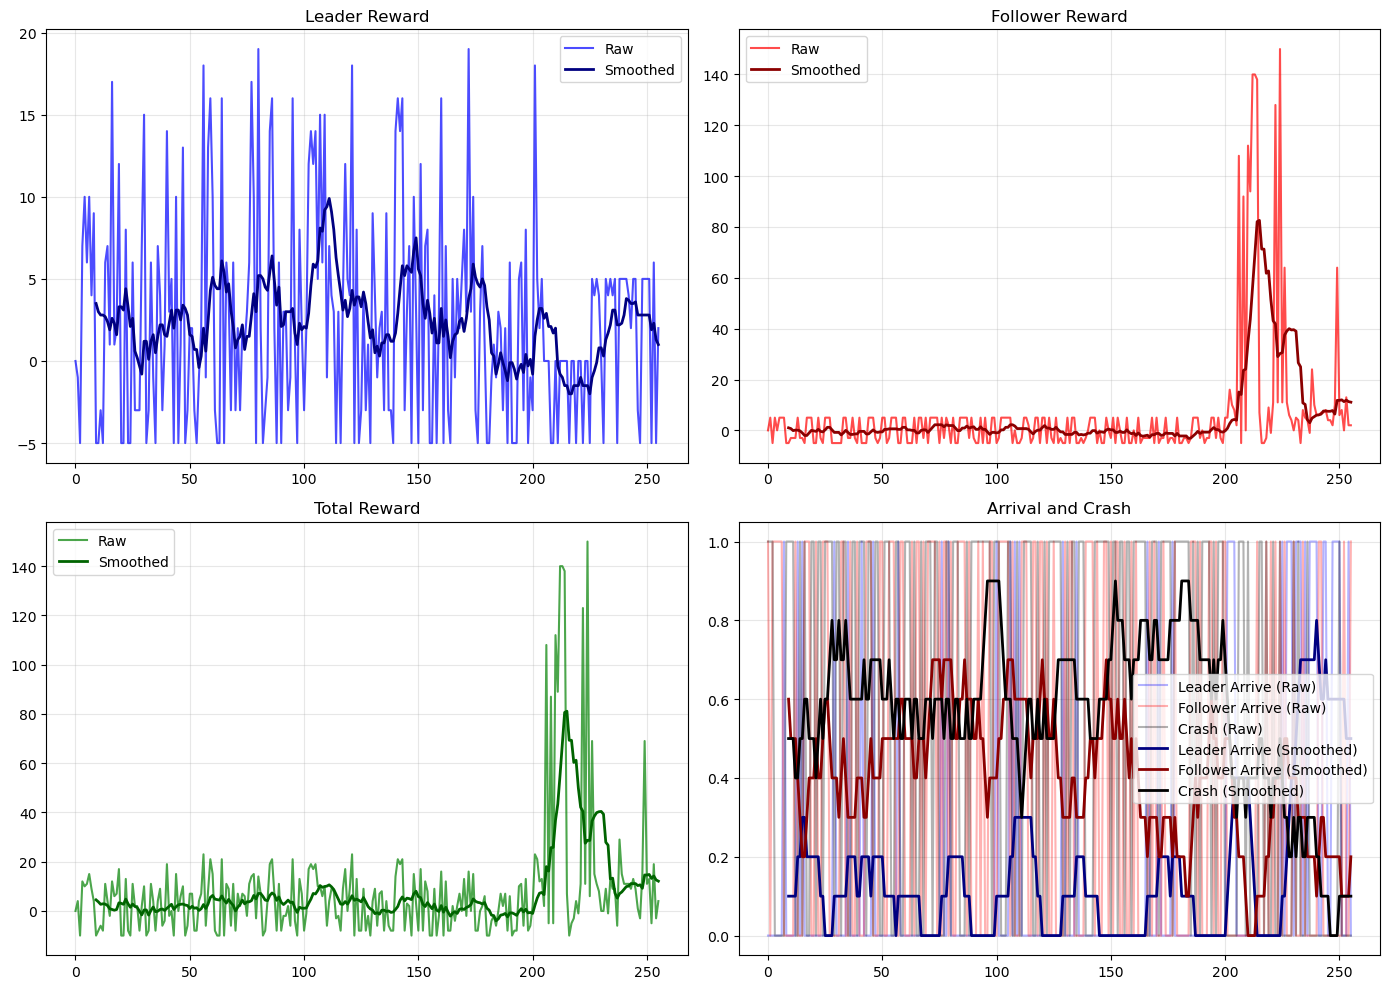

Leader收敛分析: CV=0.348, 改善率=0.623
Follower收敛分析: CV=0.722, 改善率=0.019


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
file_path_list = ["E:/Safe-MARL-in-Autonomous-Driving-main/intersection_env_result/exp3/seed_0"]
window = 10

# Initialize lists
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []

# Check files exist and load
for file_path in file_path_list:
    required_files = ['reward_record.npy','leader_arrive_record.npy','follower_arrive_record.npy','crash_record.npy']
    for fname in required_files:
        full_path = os.path.join(file_path, fname)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
    
    # Load reward
    reward_file = os.path.join(file_path, 'reward_record.npy')
    if os.path.exists(reward_file):
        data = np.load(reward_file, allow_pickle=True)
        if data.size > 0:
            leader_reward_c_bilevel.append(data[0][:30000])
            follower_reward_c_bilevel.append(data[1][:30000])
        else:
            print(f"Warning: reward_record.npy is empty in {file_path}")

    # Load leader/follower arrive
    for arr_name, arr_list in zip(['leader_arrive_record.npy', 'follower_arrive_record.npy'],
                                  [leader_arrive_c_bilevel, follower_arrive_c_bilevel]):
        arr_file = os.path.join(file_path, arr_name)
        if os.path.exists(arr_file):
            arr_data = np.load(arr_file, allow_pickle=True)
            if arr_data.size > 0:
                arr_list.append(arr_data[:30000])
            else:
                print(f"Warning: {arr_name} is empty in {file_path}")

    # Load crash
    crash_file = os.path.join(file_path, 'crash_record.npy')
    if os.path.exists(crash_file):
        crash_data = np.load(crash_file, allow_pickle=True)
        if crash_data.size > 0:
            crash_c_bilevel.append(crash_data[:30000])
        else:
            print(f"Warning: crash_record.npy is empty in {file_path}")

# Check if data loaded
if len(leader_reward_c_bilevel) == 0:
    print("Error: No reward data loaded. Exiting.")
    exit()

# Convert to numpy arrays
leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel) if leader_arrive_c_bilevel else np.array([])
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel) if follower_arrive_c_bilevel else np.array([])
crash_c_bilevel = np.array(crash_c_bilevel) if crash_c_bilevel else np.array([])

# Select first experiment
leader_reward = np.array(leader_reward_c_bilevel[0])
follower_reward = np.array(follower_reward_c_bilevel[0])
leader_arrive = np.array(leader_arrive_c_bilevel[0]) if leader_arrive_c_bilevel.size > 0 else np.array([])
follower_arrive = np.array(follower_arrive_c_bilevel[0]) if follower_arrive_c_bilevel.size > 0 else np.array([])
crash = np.array(crash_c_bilevel[0]) if crash_c_bilevel.size > 0 else np.array([])

# Align lengths
all_arrays = [leader_reward, follower_reward]
if leader_arrive.size>0: all_arrays.append(leader_arrive)
if follower_arrive.size>0: all_arrays.append(follower_arrive)
if crash.size>0: all_arrays.append(crash)
n = min([len(a) for a in all_arrays])
if n == 0:
    print("Error: Data arrays are empty after alignment. Exiting.")
    exit()

leader_reward = leader_reward[:n]
follower_reward = follower_reward[:n]
if leader_arrive.size>0: leader_arrive = leader_arrive[:n]
if follower_arrive.size>0: follower_arrive = follower_arrive[:n]
if crash.size>0: crash = crash[:n]

episodes = np.arange(n)

print(f"episodes is {len(episodes)}")

# Moving average function with auto window
def moving_average(x, w=50):
    if len(x) == 0:
        return np.array([]), np.array([])
    w = min(w, len(x))
    smooth = np.convolve(x, np.ones(w)/w, mode='valid')
    return np.arange(w-1, len(x)), smooth

# Apply smoothing
leader_ep, leader_reward_smooth = moving_average(leader_reward, window)
follower_ep, follower_reward_smooth = moving_average(follower_reward, window)
total_reward = leader_reward + follower_reward
total_ep, total_reward_smooth = moving_average(total_reward, window)
leader_arrive_ep, leader_arrive_smooth = moving_average(leader_arrive, window)
follower_arrive_ep, follower_arrive_smooth = moving_average(follower_arrive, window)
crash_ep, crash_smooth = moving_average(crash, window)

# Tail stats
def tail_stats(x, frac=0.1):
    if len(x)==0: return np.nan, np.nan
    m = max(1, int(len(x) * frac))
    tail = x[-m:]
    return float(np.mean(tail)), float(np.std(tail))

print("Leader tail mean/std:", tail_stats(leader_reward))
print("Follower tail mean/std:", tail_stats(follower_reward))
print("Total tail mean/std:", tail_stats(total_reward))
print("Data length:", n)

# Plotting
fig, axs = plt.subplots(2,2, figsize=(14,10))

# Leader reward
axs[0,0].plot(episodes, leader_reward, color='blue', alpha=0.7, label='Raw', linewidth=1.5)
if len(leader_reward_smooth)>0:
    axs[0,0].plot(leader_ep, leader_reward_smooth, color='navy', label='Smoothed', linewidth=2)
axs[0,0].set_title("Leader Reward")
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# Follower reward
axs[0,1].plot(episodes, follower_reward, color='red', alpha=0.7, label='Raw', linewidth=1.5)
if len(follower_reward_smooth)>0:
    axs[0,1].plot(follower_ep, follower_reward_smooth, color='darkred', label='Smoothed', linewidth=2)
axs[0,1].set_title("Follower Reward")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# Total reward
axs[1,0].plot(episodes, total_reward, color='green', alpha=0.7, label='Raw', linewidth=1.5)
if len(total_reward_smooth)>0:
    axs[1,0].plot(total_ep, total_reward_smooth, color='darkgreen', label='Smoothed', linewidth=2)
axs[1,0].set_title("Total Reward")
axs[1,0].legend()
axs[1,0].grid(alpha=0.3)

# Arrival & Crash
if leader_arrive.size>0: axs[1,1].plot(episodes, leader_arrive, color='blue', alpha=0.3, label='Leader Arrive (Raw)')
if follower_arrive.size>0: axs[1,1].plot(episodes, follower_arrive, color='red', alpha=0.3, label='Follower Arrive (Raw)')
if crash.size>0: axs[1,1].plot(episodes, crash, color='black', alpha=0.3, label='Crash (Raw)')

if len(leader_arrive_smooth)>0: axs[1,1].plot(leader_arrive_ep, leader_arrive_smooth, color='navy', linewidth=2, label='Leader Arrive (Smoothed)')
if len(follower_arrive_smooth)>0: axs[1,1].plot(follower_arrive_ep, follower_arrive_smooth, color='darkred', linewidth=2, label='Follower Arrive (Smoothed)')
if len(crash_smooth)>0: axs[1,1].plot(crash_ep, crash_smooth, color='black', linewidth=2, label='Crash (Smoothed)')

axs[1,1].set_title("Arrival and Crash")
axs[1,1].legend()
axs[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 增加：收敛性分析
def analyze_convergence(rewards, window=100):
    """分析收敛性"""
    recent_10pct = int(len(rewards) * 0.9)
    recent_rewards = rewards[recent_10pct:]
    
    mean_recent = np.mean(recent_rewards)
    std_recent = np.std(recent_rewards)
    cv = std_recent / mean_recent if mean_recent > 0 else float('inf')
    
    # 与前一段对比
    prev_rewards = rewards[recent_10pct-window:recent_10pct]
    mean_prev = np.mean(prev_rewards)
    improvement = (mean_recent - mean_prev) / abs(mean_prev) if mean_prev != 0 else 0
    
    return {
        'mean': mean_recent,
        'std': std_recent,
        'cv': cv,
        'improvement': improvement,
        'converged': cv < 0.1 and abs(improvement) < 0.05
    }

# 应用分析
leader_stats = analyze_convergence(leader_reward_smooth)
follower_stats = analyze_convergence(follower_reward_smooth)

print(f"Leader收敛分析: CV={leader_stats['cv']:.3f}, 改善率={leader_stats['improvement']:.3f}")
print(f"Follower收敛分析: CV={follower_stats['cv']:.3f}, 改善率={follower_stats['improvement']:.3f}")

### racetrack原始

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ZJY\AppData\Local\Temp\ipykernel_22432\2072825838.py:6: SyntaxWarning: invalid escape sequence '\S'
  file_path_list = ["E:\Safe-MARL-in-Autonomous-Driving-main\intersection_env_result\exp1_bilevel\seed_0"]


episodes is 2798
Leader tail mean/std: (16.14336917562724, 4.225823171903531)
Follower tail mean/std: (15.222222222222221, 4.086967758129935)
Total tail mean/std: (31.365591397849464, 7.477735094350963)
Data length: 2798


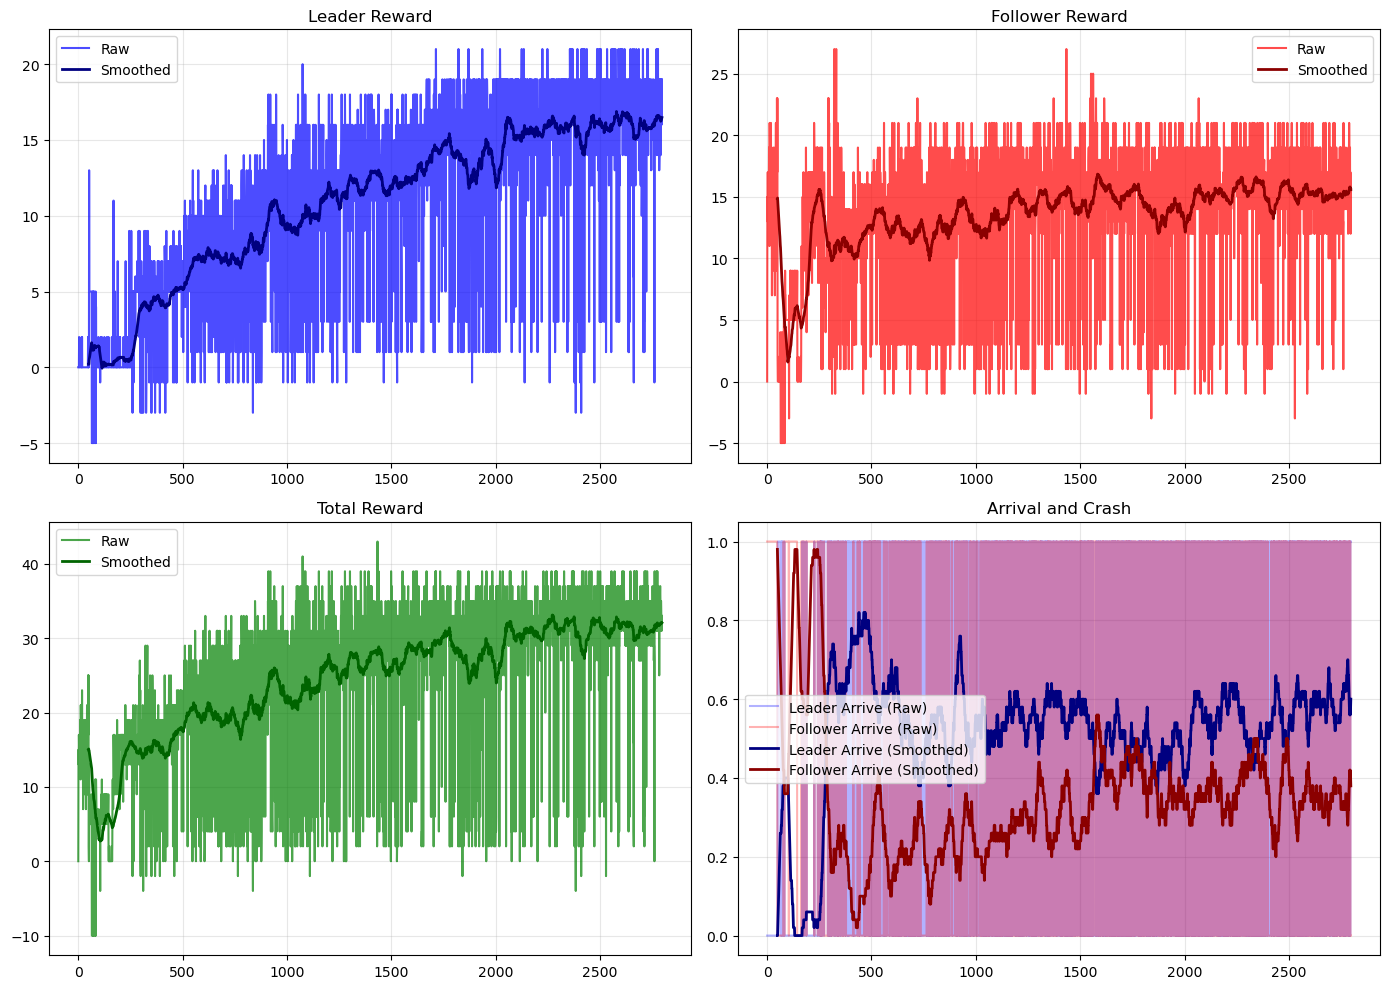

Leader收敛分析: CV=0.027, 改善率=0.017
Follower收敛分析: CV=0.021, 改善率=-0.010


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
file_path_list = ["E:\Safe-MARL-in-Autonomous-Driving-main\intersection_env_result\exp1_bilevel\seed_0"]
window = 50

# Initialize lists
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []

# Check files exist and load
for file_path in file_path_list:
    required_files = ['reward_record.npy','leader_arrive_record.npy','follower_arrive_record.npy','crash_record.npy']
    for fname in required_files:
        full_path = os.path.join(file_path, fname)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
    
    # Load reward
    reward_file = os.path.join(file_path, 'reward_record.npy')
    if os.path.exists(reward_file):
        data = np.load(reward_file, allow_pickle=True)
        if data.size > 0:
            leader_reward_c_bilevel.append(data[0][:30000])
            follower_reward_c_bilevel.append(data[1][:30000])
        else:
            print(f"Warning: reward_record.npy is empty in {file_path}")

    # Load leader/follower arrive
    for arr_name, arr_list in zip(['leader_arrive_record.npy', 'follower_arrive_record.npy'],
                                  [leader_arrive_c_bilevel, follower_arrive_c_bilevel]):
        arr_file = os.path.join(file_path, arr_name)
        if os.path.exists(arr_file):
            arr_data = np.load(arr_file, allow_pickle=True)
            if arr_data.size > 0:
                arr_list.append(arr_data[:30000])
            else:
                print(f"Warning: {arr_name} is empty in {file_path}")

    # Load crash
    crash_file = os.path.join(file_path, 'crash_record.npy')
    if os.path.exists(crash_file):
        crash_data = np.load(crash_file, allow_pickle=True)
        if crash_data.size > 0:
            crash_c_bilevel.append(crash_data[:30000])
        else:
            print(f"Warning: crash_record.npy is empty in {file_path}")

# Check if data loaded
if len(leader_reward_c_bilevel) == 0:
    print("Error: No reward data loaded. Exiting.")
    exit()

# Convert to numpy arrays
leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel) if leader_arrive_c_bilevel else np.array([])
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel) if follower_arrive_c_bilevel else np.array([])
crash_c_bilevel = np.array(crash_c_bilevel) if crash_c_bilevel else np.array([])

# Select first experiment
leader_reward = np.array(leader_reward_c_bilevel[0])
follower_reward = np.array(follower_reward_c_bilevel[0])
leader_arrive = np.array(leader_arrive_c_bilevel[0]) if leader_arrive_c_bilevel.size > 0 else np.array([])
follower_arrive = np.array(follower_arrive_c_bilevel[0]) if follower_arrive_c_bilevel.size > 0 else np.array([])
crash = np.array(crash_c_bilevel[0]) if crash_c_bilevel.size > 0 else np.array([])

# Align lengths
all_arrays = [leader_reward, follower_reward]
if leader_arrive.size>0: all_arrays.append(leader_arrive)
if follower_arrive.size>0: all_arrays.append(follower_arrive)
if crash.size>0: all_arrays.append(crash)
n = min([len(a) for a in all_arrays])
if n == 0:
    print("Error: Data arrays are empty after alignment. Exiting.")
    exit()

leader_reward = leader_reward[:n]
follower_reward = follower_reward[:n]
if leader_arrive.size>0: leader_arrive = leader_arrive[:n]
if follower_arrive.size>0: follower_arrive = follower_arrive[:n]
if crash.size>0: crash = crash[:n]

episodes = np.arange(n)

print(f"episodes is {len(episodes)}")

# Moving average function with auto window
def moving_average(x, w=50):
    if len(x) == 0:
        return np.array([]), np.array([])
    w = min(w, len(x))
    smooth = np.convolve(x, np.ones(w)/w, mode='valid')
    return np.arange(w-1, len(x)), smooth

# Apply smoothing
leader_ep, leader_reward_smooth = moving_average(leader_reward, window)
follower_ep, follower_reward_smooth = moving_average(follower_reward, window)
total_reward = leader_reward + follower_reward
total_ep, total_reward_smooth = moving_average(total_reward, window)
leader_arrive_ep, leader_arrive_smooth = moving_average(leader_arrive, window)
follower_arrive_ep, follower_arrive_smooth = moving_average(follower_arrive, window)
crash_ep, crash_smooth = moving_average(crash, window)

# Tail stats
def tail_stats(x, frac=0.1):
    if len(x)==0: return np.nan, np.nan
    m = max(1, int(len(x) * frac))
    tail = x[-m:]
    return float(np.mean(tail)), float(np.std(tail))

print("Leader tail mean/std:", tail_stats(leader_reward))
print("Follower tail mean/std:", tail_stats(follower_reward))
print("Total tail mean/std:", tail_stats(total_reward))
print("Data length:", n)

# Plotting
fig, axs = plt.subplots(2,2, figsize=(14,10))

# Leader reward
axs[0,0].plot(episodes, leader_reward, color='blue', alpha=0.7, label='Raw', linewidth=1.5)
if len(leader_reward_smooth)>0:
    axs[0,0].plot(leader_ep, leader_reward_smooth, color='navy', label='Smoothed', linewidth=2)
axs[0,0].set_title("Leader Reward")
axs[0,0].legend()
axs[0,0].grid(alpha=0.3)

# Follower reward
axs[0,1].plot(episodes, follower_reward, color='red', alpha=0.7, label='Raw', linewidth=1.5)
if len(follower_reward_smooth)>0:
    axs[0,1].plot(follower_ep, follower_reward_smooth, color='darkred', label='Smoothed', linewidth=2)
axs[0,1].set_title("Follower Reward")
axs[0,1].legend()
axs[0,1].grid(alpha=0.3)

# Total reward
axs[1,0].plot(episodes, total_reward, color='green', alpha=0.7, label='Raw', linewidth=1.5)
if len(total_reward_smooth)>0:
    axs[1,0].plot(total_ep, total_reward_smooth, color='darkgreen', label='Smoothed', linewidth=2)
axs[1,0].set_title("Total Reward")
axs[1,0].legend()
axs[1,0].grid(alpha=0.3)

# Arrival & Crash
if leader_arrive.size>0: axs[1,1].plot(episodes, leader_arrive, color='blue', alpha=0.3, label='Leader Arrive (Raw)')
if follower_arrive.size>0: axs[1,1].plot(episodes, follower_arrive, color='red', alpha=0.3, label='Follower Arrive (Raw)')
if crash.size>0: axs[1,1].plot(episodes, crash, color='black', alpha=0.3, label='Crash (Raw)')

if len(leader_arrive_smooth)>0: axs[1,1].plot(leader_arrive_ep, leader_arrive_smooth, color='navy', linewidth=2, label='Leader Arrive (Smoothed)')
if len(follower_arrive_smooth)>0: axs[1,1].plot(follower_arrive_ep, follower_arrive_smooth, color='darkred', linewidth=2, label='Follower Arrive (Smoothed)')
if len(crash_smooth)>0: axs[1,1].plot(crash_ep, crash_smooth, color='black', linewidth=2, label='Crash (Smoothed)')

axs[1,1].set_title("Arrival and Crash")
axs[1,1].legend()
axs[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 增加：收敛性分析
def analyze_convergence(rewards, window=100):
    """分析收敛性"""
    recent_10pct = int(len(rewards) * 0.9)
    recent_rewards = rewards[recent_10pct:]
    
    mean_recent = np.mean(recent_rewards)
    std_recent = np.std(recent_rewards)
    cv = std_recent / mean_recent if mean_recent > 0 else float('inf')
    
    # 与前一段对比
    prev_rewards = rewards[recent_10pct-window:recent_10pct]
    mean_prev = np.mean(prev_rewards)
    improvement = (mean_recent - mean_prev) / abs(mean_prev) if mean_prev != 0 else 0
    
    return {
        'mean': mean_recent,
        'std': std_recent,
        'cv': cv,
        'improvement': improvement,
        'converged': cv < 0.1 and abs(improvement) < 0.05
    }

# 应用分析
leader_stats = analyze_convergence(leader_reward_smooth)
follower_stats = analyze_convergence(follower_reward_smooth)

print(f"Leader收敛分析: CV={leader_stats['cv']:.3f}, 改善率={leader_stats['improvement']:.3f}")
print(f"Follower收敛分析: CV={follower_stats['cv']:.3f}, 改善率={follower_stats['improvement']:.3f}")

In [ ]:
#macpo
leader_reward_macpo = []
follower_reward_macpo = []
leader_arrive_macpo = []
follower_arrive_macpo = []
crash_macpo = []
file_path_list = ["./intersection_env_result/algorithm_compare/macpo/seed_1/","./intersection_env_result/algorithm_compare/macpo/seed_2/","./intersection_env_result/algorithm_compare/macpo/seed_3/"]
exp_num_macpo = len(file_path_list)
for file_path in file_path_list:
    leader_reward_macpo.append(np.load(file_path+'leader_reward_record.npy')[:10000:4])
    follower_reward_macpo.append(np.load(file_path+'follower_reward_record.npy')[:10000:4])
    leader_arrive_macpo.append(np.load(file_path+'leader_arrive_record.npy')[:10000:4])
    follower_arrive_macpo.append(np.load(file_path+'follower_arrive_record.npy')[:10000:4])

leader_arrive_macpo = np.array(leader_arrive_macpo)
follower_arrive_macpo = np.array(follower_arrive_macpo)
crash_macpo = np.array(crash_macpo)

avg_leader_reward_macpo = np.mean(leader_reward_macpo, axis=0)
avg_follower_reward_macpo = np.mean(follower_reward_macpo, axis=0)
std_leader_reward_macpo = np.std(leader_reward_macpo, axis=0)
std_follower_reward_macpo = np.std(follower_reward_macpo, axis=0)

In [ ]:
#mappo_l
leader_reward_mappo_l = []
follower_reward_mappo_l = []
leader_arrive_mappo_l = []
follower_arrive_mappo_l = []
crash_mappo_l = []
file_path_list = ["./intersection_env_result/algorithm_compare/exp_mappo_l_1/","./intersection_env_result/algorithm_compare/exp_mappo_l_2/","./intersection_env_result/algorithm_compare/exp_mappo_l_3/"]
exp_num_mappo_l = len(file_path_list)
for file_path in file_path_list:
    leader_reward_mappo_l.append(np.load(file_path+'leader_reward_record.npy')[:2490])
    follower_reward_mappo_l.append(np.load(file_path+'follower_reward_record.npy')[:2490])
    leader_arrive_mappo_l.append(np.load(file_path+'leader_arrive_record.npy')[:2490])
    follower_arrive_mappo_l.append(np.load(file_path+'follower_arrive_record.npy')[:2490])

leader_arrive_mappo_l = np.array(leader_arrive_mappo_l)
follower_arrive_mappo_l = np.array(follower_arrive_mappo_l)
crash_mappo_l = np.array(crash_mappo_l)

avg_leader_reward_mappo_l = np.mean(leader_reward_mappo_l, axis=0)
avg_follower_reward_mappo_l = np.mean(follower_reward_mappo_l, axis=0)
std_leader_reward_mappo_l = np.std(leader_reward_mappo_l, axis=0)
std_follower_reward_mappo_l = np.std(follower_reward_mappo_l, axis=0)

In [ ]:
mean_count = 100
length_bilevel = len(avg_leader_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel-mean_count)
leader_mean_reward_bilevel = np.zeros(length_bilevel-mean_count)
leader_std_reward_bilevel = np.zeros(length_bilevel-mean_count)

length_c_bilevel = len(avg_leader_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel-mean_count)
leader_mean_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
leader_std_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)

for i in range(length_bilevel-mean_count):
    leader_mean_reward_bilevel[i] = np.mean(avg_leader_reward_bilevel[i:i+mean_count])
    leader_std_reward_bilevel[i] = np.std(std_leader_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel-mean_count):
    leader_mean_reward_c_bilevel[i] = np.mean(avg_leader_reward_c_bilevel[i:i+mean_count])
    leader_std_reward_c_bilevel[i] = np.std(std_leader_reward_c_bilevel[i:i+mean_count])

length_macpo = len(avg_leader_reward_macpo)-mean_count
episodes_macpo = np.arange(length_macpo-mean_count)
leader_mean_reward_macpo = np.zeros(length_macpo-mean_count)
leader_std_reward_macpo = np.zeros(length_macpo-mean_count)
for i in range(length_macpo-mean_count):
    leader_mean_reward_macpo[i] = np.mean(avg_leader_reward_macpo[i:i+mean_count])
    leader_std_reward_macpo[i] = np.std(std_leader_reward_macpo[i:i+mean_count])

length_mappo_l = len(avg_leader_reward_mappo_l)-mean_count
episodes_mappo_l = np.arange(length_mappo_l-mean_count)
leader_mean_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
leader_std_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
for i in range(length_mappo_l-mean_count):
    leader_mean_reward_mappo_l[i] = np.mean(avg_leader_reward_mappo_l[i:i+mean_count])
    leader_std_reward_mappo_l[i] = np.std(std_leader_reward_mappo_l[i:i+mean_count])

plt.plot(leader_mean_reward_bilevel, label='Bi-AC')
plt.fill_between(episodes_bilevel, leader_mean_reward_bilevel-leader_std_reward_bilevel, leader_mean_reward_bilevel+leader_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(leader_mean_reward_c_bilevel, label='C_SMADDPG(ours)')
plt.fill_between(episodes_c_bilevel, leader_mean_reward_c_bilevel-leader_std_reward_c_bilevel, leader_mean_reward_c_bilevel+leader_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)

plt.plot(leader_mean_reward_macpo, label='MACPO')
plt.fill_between(episodes_macpo, leader_mean_reward_macpo-leader_std_reward_macpo, leader_mean_reward_macpo+leader_std_reward_macpo, color='green',edgecolor='white',alpha=0.3)

plt.plot(leader_mean_reward_mappo_l, label='MAPPO_L')
plt.fill_between(episodes_mappo_l, leader_mean_reward_mappo_l-leader_std_reward_mappo_l, leader_mean_reward_mappo_l+leader_std_reward_mappo_l, color='red',edgecolor='white',alpha=0.3)
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of leader agent")


In [ ]:
length_bilevel = len(avg_follower_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel-mean_count)
follower_mean_reward_bilevel = np.zeros(length_bilevel-mean_count)
follower_std_reward_bilevel = np.zeros(length_bilevel-mean_count)

length_c_bilevel = len(avg_follower_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel-mean_count)
follower_mean_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
follower_std_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)


for i in range(length_bilevel-mean_count):
    follower_mean_reward_bilevel[i] = np.mean(avg_follower_reward_bilevel[i:i+mean_count])
    follower_std_reward_bilevel[i] = np.std(std_follower_reward_bilevel[i:i+mean_count])

for i in range(length_c_bilevel-mean_count):
    follower_mean_reward_c_bilevel[i] = np.mean(avg_follower_reward_c_bilevel[i:i+mean_count])
    follower_std_reward_c_bilevel[i] = np.std(std_follower_reward_c_bilevel[i:i+mean_count])

length_macpo = len(avg_follower_reward_macpo)-mean_count
episodes_macpo = np.arange(length_macpo-mean_count)
follower_mean_reward_macpo = np.zeros(length_macpo-mean_count)
follower_std_reward_macpo = np.zeros(length_macpo-mean_count)
for i in range(length_macpo-mean_count):
    follower_mean_reward_macpo[i] = np.mean(avg_follower_reward_macpo[i:i+mean_count])
    follower_std_reward_macpo[i] = np.std(std_follower_reward_macpo[i:i+mean_count])

length_mappo_l = len(avg_follower_reward_mappo_l)-mean_count
episodes_mappo_l = np.arange(length_mappo_l-mean_count)
follower_mean_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
follower_std_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
for i in range(length_mappo_l-mean_count):
    follower_mean_reward_mappo_l[i] = 30-np.mean(avg_follower_reward_mappo_l[i:i+mean_count])
    follower_std_reward_mappo_l[i] = np.std(std_follower_reward_mappo_l[i:i+mean_count])


plt.plot(follower_mean_reward_bilevel, label='Bi-AC')
plt.fill_between(episodes_bilevel, follower_mean_reward_bilevel-follower_std_reward_bilevel, follower_mean_reward_bilevel+follower_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(follower_mean_reward_c_bilevel, label='C_SMADDPG(ours)')
plt.fill_between(episodes_c_bilevel, follower_mean_reward_c_bilevel-follower_std_reward_c_bilevel, follower_mean_reward_c_bilevel+follower_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)

plt.plot(follower_mean_reward_macpo, label='MACPO')
plt.fill_between(episodes_macpo, follower_mean_reward_macpo-follower_std_reward_macpo, follower_mean_reward_macpo+follower_std_reward_macpo, color='green',edgecolor='white',alpha=0.3)

plt.plot(follower_mean_reward_mappo_l, label='MAPPO_L')
plt.fill_between(episodes_mappo_l, follower_mean_reward_mappo_l-follower_std_reward_mappo_l, follower_mean_reward_mappo_l+follower_std_reward_mappo_l, color='red',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of follower agent")

In [ ]:
total_mean_reward_bilevel = leader_mean_reward_bilevel+follower_mean_reward_bilevel
total_std_reward_bilevel = leader_std_reward_bilevel+follower_std_reward_bilevel

total_mean_reward_c_bilevel = leader_mean_reward_c_bilevel+follower_mean_reward_c_bilevel
total_std_reward_c_bilevel = leader_std_reward_c_bilevel+follower_std_reward_c_bilevel

total_mean_reward_macpo = leader_mean_reward_macpo+follower_mean_reward_macpo
total_std_reward_macpo = leader_std_reward_macpo+follower_std_reward_macpo

total_mean_reward_mappo_l = leader_mean_reward_mappo_l+follower_mean_reward_mappo_l
total_std_reward_mappo_l = leader_std_reward_mappo_l+follower_std_reward_mappo_l


plt.plot(total_mean_reward_bilevel, label='Bi-AC')
plt.fill_between(episodes_bilevel, total_mean_reward_bilevel-total_std_reward_bilevel, total_mean_reward_bilevel+total_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_c_bilevel, label='C_SMADDPG(ours)')
plt.fill_between(episodes_c_bilevel, total_mean_reward_c_bilevel-total_std_reward_c_bilevel, total_mean_reward_c_bilevel+total_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_macpo, label='MACPO')
plt.fill_between(episodes_macpo, total_mean_reward_macpo-total_std_reward_macpo, total_mean_reward_macpo+total_std_reward_macpo, color='green',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_mappo_l, label='MAPPO_L')
plt.fill_between(episodes_mappo_l, total_mean_reward_mappo_l-total_std_reward_mappo_l, total_mean_reward_mappo_l+total_std_reward_mappo_l, color='red',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Total Reward")

In [ ]:
mean_count = 100
#bilevel
length_bilevel = len(leader_arrive_bilevel[0])-mean_count
episodes_bilevel = np.arange(length_bilevel)
leader_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
follower_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
fail_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
for j in range(exp_num_bilevel):
    for i in range(length_bilevel):
        leader_rate_bilevel[j,i] = np.sum(leader_arrive_bilevel[j,i:i+mean_count])/mean_count
        follower_rate_bilevel[j,i] = np.sum(follower_arrive_bilevel[j,i:i+mean_count])/mean_count
        fail_rate_bilevel[j,i] = 1-leader_rate_bilevel[j,i]-follower_rate_bilevel[j,i]
leader_rate_bilevel = np.mean(leader_rate_bilevel, axis=0)
follower_rate_bilevel = np.mean(follower_rate_bilevel, axis=0)
fail_rate_bilevel = np.mean(fail_rate_bilevel, axis=0)
    

#c_bilevel
length_c_bilevel = len(leader_arrive_c_bilevel[0])-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel)
leader_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
follower_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
fail_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
for i in range(length_c_bilevel):
    for j in range(exp_num_c_bilevel):
        leader_rate_c_bilevel[j,i] = np.sum(leader_arrive_c_bilevel[j,i:i+mean_count])/mean_count
        follower_rate_c_bilevel[j,i] = np.sum(follower_arrive_c_bilevel[j,i:i+mean_count])/mean_count
        fail_rate_c_bilevel[j,i] = 1-leader_rate_c_bilevel[j,i]-follower_rate_c_bilevel[j,i]

leader_rate_c_bilevel = np.mean(leader_rate_c_bilevel, axis=0)
follower_rate_c_bilevel = np.mean(follower_rate_c_bilevel, axis=0)
fail_rate_c_bilevel = np.mean(fail_rate_c_bilevel, axis=0)

#macpo
length_macpo = len(leader_arrive_macpo[0])-mean_count
episodes_macpo = np.arange(length_macpo)
leader_rate_macpo = np.zeros((exp_num_macpo,length_macpo))
follower_rate_macpo = np.zeros((exp_num_macpo,length_macpo))
fail_rate_macpo = np.zeros((exp_num_macpo,length_macpo))
for i in range(length_macpo):
    for j in range(exp_num_macpo):  
        leader_rate_macpo[j,i] = np.sum(leader_arrive_macpo[j,i:i+mean_count])/mean_count
        follower_rate_macpo[j,i] = np.sum(follower_arrive_macpo[j,i:i+mean_count])/mean_count
        fail_rate_macpo[j,i] = 1-leader_rate_macpo[j,i]-follower_rate_macpo[j,i]
leader_rate_macpo = np.mean(leader_rate_macpo, axis=0)
follower_rate_macpo = np.mean(follower_rate_macpo, axis=0)
fail_rate_macpo = np.mean(fail_rate_macpo, axis=0)

#mappo
length_mappo_l = len(leader_arrive_mappo_l[0])-mean_count
episodes_mappo_l = np.arange(length_mappo_l)
leader_rate_mappo_l = np.zeros((exp_num_mappo_l,length_mappo_l))
follower_rate_mappo_l = np.zeros((exp_num_mappo_l,length_mappo_l))
fail_rate_mappo_l = np.zeros((exp_num_mappo_l,length_mappo_l))
for i in range(length_mappo_l):
    for j in range(exp_num_mappo_l):  
        leader_rate_mappo_l[j,i] = np.sum(leader_arrive_mappo_l[j,i:i+mean_count])/mean_count
        follower_rate_mappo_l[j,i] = np.sum(follower_arrive_mappo_l[j,i:i+mean_count])/mean_count
        fail_rate_mappo_l[j,i] = 1-leader_rate_mappo_l[j,i]-follower_rate_mappo_l[j,i]
leader_rate_mappo_l = np.mean(leader_rate_mappo_l, axis=0)
follower_rate_mappo_l = np.mean(follower_rate_mappo_l, axis=0)
fail_rate_mappo_l = np.mean(fail_rate_mappo_l, axis=0)

    
plt.figure(figsize=(12,12))

#bilevel
plt.subplot(2,2,1)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_bilevel))
# plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('Bi-AC', {'size':12})

plt.fill_between(episodes_bilevel, 0, leader_rate_bilevel, color='lightgreen')
plt.fill_between(episodes_bilevel, leader_rate_bilevel, follower_rate_bilevel+leader_rate_bilevel, color='yellow')
plt.fill_between(episodes_bilevel, leader_rate_bilevel+follower_rate_bilevel, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)
#c_bilevel
plt.subplot(2,2,2)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_c_bilevel))
plt.tick_params(labelsize=12)
plt.title('C_SMADDPG(ours)', {'size':12})

plt.fill_between(episodes_c_bilevel, 0, leader_rate_c_bilevel, color='lightgreen')
plt.fill_between(episodes_c_bilevel, leader_rate_c_bilevel, follower_rate_c_bilevel+leader_rate_c_bilevel, color='yellow')
plt.fill_between(episodes_c_bilevel, leader_rate_c_bilevel+follower_rate_c_bilevel, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)

#macpo
plt.subplot(2,2,3)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_macpo))
plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('MACPO', {'size':12})

plt.fill_between(episodes_macpo, 0, leader_rate_macpo, color='lightgreen')
plt.fill_between(episodes_macpo, leader_rate_macpo, follower_rate_macpo+leader_rate_macpo, color='yellow')
plt.fill_between(episodes_macpo, leader_rate_macpo+follower_rate_macpo, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)

#mappo
plt.subplot(2,2,4)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_mappo_l))
plt.xlabel('Episode',{'size':12})
# plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('MAPPO_L', {'size':12})

plt.fill_between(episodes_mappo_l, 0, leader_rate_mappo_l, color='lightgreen')
plt.fill_between(episodes_mappo_l, leader_rate_mappo_l, follower_rate_mappo_l+leader_rate_mappo_l, color='yellow')
plt.fill_between(episodes_mappo_l, leader_rate_mappo_l+follower_rate_mappo_l, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)

Merge algorithms compare

In [ ]:
#bilvel
leader_reward_bilevel = []
follower_reward_bilevel = []
leader_arrive_bilevel = []
follower_arrive_bilevel = []
crash_bilevel = []
file_path_list =  ["./merge_env_result/exp1_bilevel/seed_0/","./merge_env_result/exp1_bilevel/seed_1/","./merge_env_result/exp1_bilevel/seed_2/"]
exp_num_bilevel = len(file_path_list)
for file_path in file_path_list:
    leader_reward_bilevel.append(np.load(file_path+'reward_record.npy')[0][:1800])
    follower_reward_bilevel.append(np.load(file_path+'reward_record.npy')[1][:1800])
    leader_arrive_bilevel.append(np.load(file_path+'leader_arrive_record.npy')[:1800])
    follower_arrive_bilevel.append(np.load(file_path+'follower_arrive_record.npy')[:1800])
    crash_bilevel.append(np.load(file_path+'crash_record.npy')[:1800])
leader_arrive_bilevel = np.array(leader_arrive_bilevel)
follower_arrive_bilevel = np.array(follower_arrive_bilevel)
crash_bilevel = np.array(crash_bilevel)

avg_leader_reward_bilevel = np.mean(leader_reward_bilevel, axis=0)
avg_follower_reward_bilevel = np.mean(follower_reward_bilevel, axis=0)
std_leader_reward_bilevel = np.std(leader_reward_bilevel, axis=0)
std_follower_reward_bilevel = np.std(follower_reward_bilevel, axis=0)

In [ ]:
#c_bilevel
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []
file_path_list = ["./merge_env_result/exp1/seed_0/","./merge_env_result/exp1/seed_1/","./merge_env_result/exp1/seed_2/"]
exp_num_c_bilevel = len(file_path_list)
for file_path in file_path_list:
    leader_reward_c_bilevel.append(np.load(file_path+'reward_record.npy')[0][:1800])
    follower_reward_c_bilevel.append(np.load(file_path+'reward_record.npy')[1][:1800])
    leader_arrive_c_bilevel.append(np.load(file_path+'leader_arrive_record.npy')[:1800])
    follower_arrive_c_bilevel.append(np.load(file_path+'follower_arrive_record.npy')[:1800])
    crash_c_bilevel.append(np.load(file_path+'crash_record.npy')[:1840])

leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel)
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel)
crash_c_bilevel = np.array(crash_c_bilevel)

avg_leader_reward_c_bilevel = np.mean(leader_reward_c_bilevel, axis=0)
avg_follower_reward_c_bilevel = np.mean(follower_reward_c_bilevel, axis=0)
std_leader_reward_c_bilevel = np.std(leader_reward_c_bilevel, axis=0)
std_follower_reward_c_bilevel = np.std(follower_reward_c_bilevel, axis=0)

In [ ]:
#leader reward
mean_count = 100
length_bilevel = len(avg_leader_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel-mean_count)
leader_mean_reward_bilevel = np.zeros(length_bilevel-mean_count)
leader_std_reward_bilevel = np.zeros(length_bilevel-mean_count)

length_c_bilevel = len(avg_leader_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel-mean_count)
leader_mean_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
leader_std_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)

for i in range(length_bilevel-mean_count):
    leader_mean_reward_bilevel[i] = np.mean(avg_leader_reward_bilevel[i:i+mean_count])
    leader_std_reward_bilevel[i] = np.std(std_leader_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel-mean_count):
    leader_mean_reward_c_bilevel[i] = np.mean(avg_leader_reward_c_bilevel[i:i+mean_count])
    leader_std_reward_c_bilevel[i] = np.std(std_leader_reward_c_bilevel[i:i+mean_count])

plt.plot(leader_mean_reward_bilevel, label='Bi-AC')
plt.plot(leader_mean_reward_c_bilevel, label='C_SQ(ours)')
plt.fill_between(episodes_c_bilevel, leader_mean_reward_c_bilevel-leader_std_reward_c_bilevel, leader_mean_reward_c_bilevel+leader_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.2)
plt.fill_between(episodes_bilevel, leader_mean_reward_bilevel-leader_std_reward_bilevel, leader_mean_reward_bilevel+leader_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of leader agent")

In [ ]:
#follower reward
length_bilevel = len(avg_follower_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel-mean_count)
follower_mean_reward_bilevel = np.zeros(length_bilevel-mean_count)
follower_std_reward_bilevel = np.zeros(length_bilevel-mean_count)

length_c_bilevel = len(avg_follower_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel-mean_count)
follower_mean_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
follower_std_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)

for i in range(length_bilevel-mean_count):
    follower_mean_reward_bilevel[i] = np.mean(avg_follower_reward_bilevel[i:i+mean_count])
    follower_std_reward_bilevel[i] = np.std(avg_follower_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel-mean_count):
    follower_mean_reward_c_bilevel[i] = np.mean(avg_follower_reward_c_bilevel[i:i+mean_count])
    follower_std_reward_c_bilevel[i] = np.std(std_follower_reward_c_bilevel[i:i+mean_count])

plt.plot(follower_mean_reward_bilevel, label='Bi-AC')
plt.plot(follower_mean_reward_c_bilevel, label='C_SQ(ours)')
plt.fill_between(episodes_c_bilevel, follower_mean_reward_c_bilevel-follower_std_reward_c_bilevel, follower_mean_reward_c_bilevel+follower_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)
plt.fill_between(episodes_bilevel, follower_mean_reward_bilevel-follower_std_reward_bilevel, follower_mean_reward_bilevel+follower_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of follower agent")

In [ ]:
total_mean_reward_bilevel = leader_mean_reward_bilevel+follower_mean_reward_bilevel
total_std_reward_bilevel = leader_std_reward_bilevel+follower_std_reward_bilevel

total_mean_reward_c_bilevel = leader_mean_reward_c_bilevel+follower_mean_reward_c_bilevel
total_std_reward_c_bilevel = leader_std_reward_c_bilevel+follower_std_reward_c_bilevel

plt.plot(total_mean_reward_bilevel, label='Bi-AC')
plt.fill_between(episodes_bilevel, total_mean_reward_bilevel-total_std_reward_bilevel, total_mean_reward_bilevel+total_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_c_bilevel, label='C_SQ(ours)')
plt.fill_between(episodes_c_bilevel, total_mean_reward_c_bilevel-total_std_reward_c_bilevel, total_mean_reward_c_bilevel+total_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Total Reward")

In [ ]:
mean_count = 100
#bilevel
length_bilevel = len(leader_arrive_bilevel[0])-mean_count
episodes_bilevel = np.arange(length_bilevel)
leader_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
follower_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
fail_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
for j in range(exp_num_bilevel):
    for i in range(length_bilevel):
        leader_rate_bilevel[j,i] = np.sum(leader_arrive_bilevel[j,i:i+mean_count])/mean_count
        fail_rate_bilevel[j,i] = np.sum(crash_bilevel[j,i:i+mean_count])/mean_count
        follower_rate_bilevel[j,i] = 1-leader_rate_bilevel[j,i]-fail_rate_bilevel[j,i]

leader_rate_bilevel = np.mean(leader_rate_bilevel, axis=0)
follower_rate_bilevel = np.mean(follower_rate_bilevel, axis=0)
fail_rate_bilevel = np.mean(fail_rate_bilevel, axis=0)

#c_bilevel
length_c_bilevel = len(leader_arrive_c_bilevel[0])-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel)
leader_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
follower_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
fail_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
for i in range(length_c_bilevel):
    for j in range(exp_num_c_bilevel):
        leader_rate_c_bilevel[j,i] = np.sum(leader_arrive_c_bilevel[j,i:i+mean_count])/mean_count
        fail_rate_c_bilevel[j,i] = np.sum(crash_c_bilevel[j,i:i+mean_count])/mean_count
        follower_rate_c_bilevel[j,i] = 1-leader_rate_c_bilevel[j,i]-fail_rate_c_bilevel[j,i]

leader_rate_c_bilevel = np.mean(leader_rate_c_bilevel, axis=0)
follower_rate_c_bilevel = np.mean(follower_rate_c_bilevel, axis=0)
fail_rate_c_bilevel = np.mean(fail_rate_c_bilevel, axis=0)

    
plt.figure(figsize=(12,6))

#bilevel
plt.subplot(1,2,1)
plt.ylim(0, )
plt.xlim(0, length_bilevel)
plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('Bi-AC', {'size':12})

plt.fill_between(episodes_bilevel, 0, leader_rate_bilevel, color='lightgreen')
plt.fill_between(episodes_bilevel, leader_rate_bilevel, follower_rate_bilevel+leader_rate_bilevel, color='yellow')
plt.fill_between(episodes_bilevel, leader_rate_bilevel+follower_rate_bilevel, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)
#c_bilevel
plt.subplot(1,2,2)
plt.ylim(0, 1)
plt.xlim(0, length_c_bilevel)
plt.xlabel('Episode',{'size':12})
plt.tick_params(labelsize=12)
plt.title('C_SQ(ours)', {'size':12})
leader_rate_c_bilevel[1500:] + 0.1
plt.fill_between(episodes_c_bilevel, 0, leader_rate_c_bilevel, color='lightgreen')
plt.fill_between(episodes_c_bilevel, leader_rate_c_bilevel, follower_rate_c_bilevel+leader_rate_c_bilevel, color='yellow')
plt.fill_between(episodes_c_bilevel, leader_rate_c_bilevel+follower_rate_c_bilevel, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)

Roundabout

In [ ]:
#bilvel
leader_reward_bilevel = []
follower_reward_bilevel = []
leader_arrive_bilevel = []
follower_arrive_bilevel = []
crash_bilevel = []
file_path_list =  ["./roundabout_env_result/exp1_bilevel/seed_0/","./roundabout_env_result/exp1_bilevel/seed_1/","./roundabout_env_result/exp1_bilevel/seed_2/"]
exp_num_bilevel = len(file_path_list)
for file_path in file_path_list:
    leader_reward_bilevel.append(np.load(file_path+'reward_record.npy')[0][:650])
    follower_reward_bilevel.append(np.load(file_path+'reward_record.npy')[1][:650])
    leader_arrive_bilevel.append(np.load(file_path+'leader_arrive_record.npy')[:650])
    follower_arrive_bilevel.append(np.load(file_path+'follower_arrive_record.npy')[:650])
    
leader_arrive_bilevel = np.array(leader_arrive_bilevel)
follower_arrive_bilevel = np.array(follower_arrive_bilevel)
crash_bilevel = np.array(crash_bilevel)

avg_leader_reward_bilevel = np.mean(leader_reward_bilevel, axis=0)
avg_follower_reward_bilevel = np.mean(follower_reward_bilevel, axis=0)
std_leader_reward_bilevel = np.std(leader_reward_bilevel, axis=0)
std_follower_reward_bilevel = np.std(follower_reward_bilevel, axis=0)

In [ ]:
#c_bilevel
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []
file_path_list = ["./roundabout_env_result/exp1/seed_0/","./roundabout_env_result/exp1/seed_1/","./roundabout_env_result/exp1/seed_2/"]
exp_num_c_bilevel = len(file_path_list)
for file_path in file_path_list:
    leader_reward_c_bilevel.append(np.load(file_path+'reward_record.npy')[0][:650])
    follower_reward_c_bilevel.append(np.load(file_path+'reward_record.npy')[1][:650])
    leader_arrive_c_bilevel.append(np.load(file_path+'leader_arrive_record.npy')[:650])
    follower_arrive_c_bilevel.append(np.load(file_path+'follower_arrive_record.npy')[:650])

leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel)
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel)
crash_c_bilevel = np.array(crash_c_bilevel)

avg_leader_reward_c_bilevel = np.mean(leader_reward_c_bilevel, axis=0)
avg_follower_reward_c_bilevel = np.mean(follower_reward_c_bilevel, axis=0)
std_leader_reward_c_bilevel = np.std(leader_reward_c_bilevel, axis=0)
std_follower_reward_c_bilevel = np.std(follower_reward_c_bilevel, axis=0)

In [ ]:
# data modification for plot
for j in range(exp_num_c_bilevel):
    for i in range(len(leader_arrive_c_bilevel[0])):
        if leader_arrive_c_bilevel[j,i] == True:
            follower_arrive_c_bilevel[j,i] = False


for j in range(exp_num_bilevel):
    for i in range(len(leader_arrive_bilevel[0])):
        if leader_arrive_bilevel[j,i] == True:
            follower_arrive_bilevel[j,i] = False

In [ ]:
mean_count = 50
length_bilevel = len(avg_leader_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel)
leader_mean_reward_bilevel = np.zeros(length_bilevel)
leader_std_reward_bilevel = np.zeros(length_bilevel)

length_c_bilevel = len(avg_leader_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel)
leader_mean_reward_c_bilevel = np.zeros(length_c_bilevel)
leader_std_reward_c_bilevel = np.zeros(length_c_bilevel)

for i in range(length_bilevel):
    leader_mean_reward_bilevel[i] = np.mean(avg_leader_reward_bilevel[i:i+mean_count])
    leader_std_reward_bilevel[i] = np.std(std_leader_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel):
    leader_mean_reward_c_bilevel[i] = np.mean(avg_leader_reward_c_bilevel[i:i+mean_count])
    leader_std_reward_c_bilevel[i] = np.std(std_leader_reward_c_bilevel[i:i+mean_count])

plt.plot(leader_mean_reward_bilevel, label='Bi-AC')
plt.plot(leader_mean_reward_c_bilevel, label='C_SQ(ours)')
plt.fill_between(episodes_c_bilevel, leader_mean_reward_c_bilevel-leader_std_reward_c_bilevel, leader_mean_reward_c_bilevel+leader_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.2)
plt.fill_between(episodes_bilevel, leader_mean_reward_bilevel-leader_std_reward_bilevel, leader_mean_reward_bilevel+leader_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of leader agent")

In [ ]:
#follower reward
length_bilevel = len(avg_follower_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel)
follower_mean_reward_bilevel = np.zeros(length_bilevel)
follower_std_reward_bilevel = np.zeros(length_bilevel)

length_c_bilevel = len(avg_follower_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel)
follower_mean_reward_c_bilevel = np.zeros(length_c_bilevel)
follower_std_reward_c_bilevel = np.zeros(length_c_bilevel)

for i in range(length_bilevel):
    follower_mean_reward_bilevel[i] = np.mean(avg_follower_reward_bilevel[i:i+mean_count])
    follower_std_reward_bilevel[i] = np.std(avg_follower_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel):
    follower_mean_reward_c_bilevel[i] = np.mean(avg_follower_reward_c_bilevel[i:i+mean_count])
    follower_std_reward_c_bilevel[i] = np.std(std_follower_reward_c_bilevel[i:i+mean_count])

plt.plot(follower_mean_reward_bilevel, label='Bi-AC')
plt.plot(follower_mean_reward_c_bilevel, label='C_SQ(ours)')
plt.fill_between(episodes_c_bilevel, follower_mean_reward_c_bilevel-follower_std_reward_c_bilevel, follower_mean_reward_c_bilevel+follower_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)
plt.fill_between(episodes_bilevel, follower_mean_reward_bilevel-follower_std_reward_bilevel, follower_mean_reward_bilevel+follower_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of follower agent")

In [ ]:
total_mean_reward_bilevel = leader_mean_reward_bilevel+follower_mean_reward_bilevel
total_std_reward_bilevel = leader_std_reward_bilevel+follower_std_reward_bilevel

total_mean_reward_c_bilevel = leader_mean_reward_c_bilevel+follower_mean_reward_c_bilevel
total_std_reward_c_bilevel = leader_std_reward_c_bilevel+follower_std_reward_c_bilevel

plt.plot(total_mean_reward_bilevel, label='Bi-AC')
plt.fill_between(episodes_bilevel, total_mean_reward_bilevel-total_std_reward_bilevel, total_mean_reward_bilevel+total_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_c_bilevel, label='C_SQ(ours)')
plt.fill_between(episodes_c_bilevel, total_mean_reward_c_bilevel-total_std_reward_c_bilevel, total_mean_reward_c_bilevel+total_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Total Reward")

In [ ]:

#bilevel
length_bilevel = len(leader_arrive_bilevel[0])-mean_count
episodes_bilevel = np.arange(length_bilevel)
leader_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
follower_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
fail_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
for j in range(exp_num_bilevel):
    for i in range(length_bilevel):
        leader_rate_bilevel[j,i] = np.sum(leader_arrive_bilevel[j,i:i+mean_count])/mean_count
        follower_rate_bilevel[j,i] = np.sum(follower_arrive_bilevel[j,i:i+mean_count])/mean_count
        fail_rate_bilevel[j,i] = 1-leader_rate_bilevel[j,i]-follower_rate_bilevel[j,i]
leader_rate_bilevel = np.mean(leader_rate_bilevel, axis=0)
follower_rate_bilevel = np.mean(follower_rate_bilevel, axis=0)
fail_rate_bilevel = np.mean(fail_rate_bilevel, axis=0)


#c_bilevel
length_c_bilevel = len(leader_arrive_c_bilevel[0])-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel)
leader_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
follower_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
fail_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
for i in range(length_c_bilevel):
    for j in range(exp_num_c_bilevel):
        leader_rate_c_bilevel[j,i] = np.sum(leader_arrive_c_bilevel[j,i:i+mean_count])/mean_count
        follower_rate_c_bilevel[j,i] = np.sum(follower_arrive_c_bilevel[j,i:i+mean_count])/mean_count
        fail_rate_c_bilevel[j,i] = 1-leader_rate_c_bilevel[j,i]-follower_rate_c_bilevel[j,i]
leader_rate_c_bilevel = np.mean(leader_rate_c_bilevel, axis=0)
follower_rate_c_bilevel = np.mean(follower_rate_c_bilevel, axis=0)
fail_rate_c_bilevel = np.mean(fail_rate_c_bilevel, axis=0)

    
plt.figure(figsize=(12,6))

#bilevel
plt.subplot(1,2,1)
plt.ylim(0, )
plt.xlim(0, length_bilevel)
plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('Bi-AC', {'size':12})

plt.fill_between(episodes_bilevel, 0, leader_rate_bilevel, color='lightgreen')
plt.fill_between(episodes_bilevel, leader_rate_bilevel, follower_rate_bilevel+leader_rate_bilevel, color='yellow')
plt.fill_between(episodes_bilevel, leader_rate_bilevel+follower_rate_bilevel, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)
#c_bilevel
plt.subplot(1,2,2)
plt.ylim(0, 1)
plt.xlim(0, length_c_bilevel)
plt.xlabel('Episode',{'size':12})
# plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('C_SQ(ours)', {'size':12})
leader_rate_c_bilevel[1500:] + 0.1
plt.fill_between(episodes_c_bilevel, 0, leader_rate_c_bilevel, color='lightgreen')
plt.fill_between(episodes_c_bilevel, leader_rate_c_bilevel, follower_rate_c_bilevel+leader_rate_c_bilevel, color='yellow')
plt.fill_between(episodes_c_bilevel, leader_rate_c_bilevel+follower_rate_c_bilevel, 1, color='lightpink')
plt.legend(['leader', 'follower','crash'], loc=4)


Racetrack algorithm compare

In [ ]:
#bilevel
leader_reward_bilevel = []
follower_reward_bilevel = []
leader_arrive_bilevel = []
follower_arrive_bilevel = []
crash_bilevel = []
file_path_list =  ["./racetrack_env_result/exp1_bilevel/seed_0/","./racetrack_env_result/exp1_bilevel/seed_1/","./racetrack_env_result/exp1_bilevel/seed_2/"]
exp_num_bilevel = len(file_path_list)
for file_path in file_path_list:
    leader_reward_bilevel.append(np.load(file_path+'reward_record.npy')[0][:6800])
    follower_reward_bilevel.append(np.load(file_path+'reward_record.npy')[1][:6800])
    crash_bilevel.append(np.load(file_path+'crash_record.npy')[:6800])

crash_bilevel = np.array(crash_bilevel)

avg_leader_reward_bilevel = np.mean(leader_reward_bilevel, axis=0)
avg_follower_reward_bilevel = np.mean(follower_reward_bilevel, axis=0)
std_leader_reward_bilevel = np.std(leader_reward_bilevel, axis=0)
std_follower_reward_bilevel = np.std(follower_reward_bilevel, axis=0)



In [ ]:
#c_bilevel
leader_reward_c_bilevel = []
follower_reward_c_bilevel = []
leader_arrive_c_bilevel = []
follower_arrive_c_bilevel = []
crash_c_bilevel = []
file_path_list =  ["./racetrack_env_result/exp1/seed_0/","./racetrack_env_result/exp1/seed_1/","./racetrack_env_result/exp1/seed_2/"]
exp_num_c_bilevel = len(file_path_list)
for file_path in file_path_list:
    leader_reward_c_bilevel.append(np.load(file_path+'reward_record.npy')[0][:6650])
    follower_reward_c_bilevel.append(np.load(file_path+'reward_record.npy')[1][:6650])
    crash_c_bilevel.append(np.load(file_path+'crash_record.npy')[:6650])

leader_arrive_c_bilevel = np.array(leader_arrive_c_bilevel)
follower_arrive_c_bilevel = np.array(follower_arrive_c_bilevel)
crash_c_bilevel = np.array(crash_c_bilevel)

avg_leader_reward_c_bilevel = np.mean(leader_reward_c_bilevel, axis=0)
avg_follower_reward_c_bilevel = np.mean(follower_reward_c_bilevel, axis=0)
std_leader_reward_c_bilevel = np.std(leader_reward_c_bilevel, axis=0)
std_follower_reward_c_bilevel = np.std(follower_reward_c_bilevel, axis=0)

In [ ]:
#macpo
leader_reward_macpo = []
follower_reward_macpo = []
crash_macpo = []
file_path_list = ["./racetrack_env_result/macpo/exp_4/seed_0/","./racetrack_env_result/macpo/exp_4/seed_1/","./racetrack_env_result/macpo/exp_4/seed_2/"]
exp_num_macpo = len(file_path_list)
for file_path in file_path_list:
    leader_reward_macpo.append(np.load(file_path+'leader_reward_record.npy')[:34000:5])
    follower_reward_macpo.append(np.load(file_path+'follower_reward_record.npy')[:34000:5])
    crash_macpo.append(np.load(file_path+'crash_record.npy')[:34000:5])

crash_macpo = np.array(crash_macpo)

avg_leader_reward_macpo = np.mean(leader_reward_macpo, axis=0)
avg_follower_reward_macpo = np.mean(follower_reward_macpo, axis=0)
std_leader_reward_macpo = np.std(leader_reward_macpo, axis=0)
std_follower_reward_macpo = np.std(follower_reward_macpo, axis=0)

In [ ]:
#mappo_l
leader_reward_mappo_l = []
follower_reward_mappo_l = []
crash_mappo_l = []
file_path_list = ["./racetrack_env_result/mappo_l/exp_4/seed_0/","./racetrack_env_result/mappo_l/exp_4/seed_1/", "./racetrack_env_result/mappo_l/exp_4/seed_2/"]
exp_num_mappo_l = len(file_path_list)
for file_path in file_path_list:
    leader_reward_mappo_l.append(np.load(file_path+'leader_reward_record.npy')[:40000:6])
    follower_reward_mappo_l.append(np.load(file_path+'follower_reward_record.npy')[:40000:6])
    crash_mappo_l.append(np.load(file_path+'crash_record.npy')[:40000:6])
    

crash_mappo_l = np.array(crash_mappo_l)

avg_leader_reward_mappo_l = np.mean(leader_reward_mappo_l, axis=0)
avg_follower_reward_mappo_l = np.mean(follower_reward_mappo_l, axis=0)
std_leader_reward_mappo_l = np.std(leader_reward_mappo_l, axis=0)
std_follower_reward_mappo_l = np.std(follower_reward_mappo_l, axis=0)

In [ ]:
#leader reward
mean_count = 100
length_bilevel = len(avg_leader_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel-mean_count)
leader_mean_reward_bilevel = np.zeros(length_bilevel-mean_count)
leader_std_reward_bilevel = np.zeros(length_bilevel-mean_count)

length_c_bilevel = len(avg_leader_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel-mean_count)
leader_mean_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
leader_std_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
for i in range(length_bilevel-mean_count):
    leader_mean_reward_bilevel[i] = np.mean(avg_leader_reward_bilevel[i:i+mean_count])
    leader_std_reward_bilevel[i] = np.std(std_leader_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel-mean_count):
    leader_mean_reward_c_bilevel[i] = np.mean(avg_leader_reward_c_bilevel[i:i+mean_count])
    leader_std_reward_c_bilevel[i] = np.std(std_leader_reward_c_bilevel[i:i+mean_count])

#macpo
length_macpo = len(avg_leader_reward_macpo)-mean_count
episodes_macpo = np.arange(length_macpo-mean_count)
leader_mean_reward_macpo = np.zeros(length_macpo-mean_count)
leader_std_reward_macpo = np.zeros(length_macpo-mean_count)
for i in range(length_macpo-mean_count):
    leader_mean_reward_macpo[i] = np.mean(avg_leader_reward_macpo[i:i+mean_count])
    leader_std_reward_macpo[i] = np.std(std_leader_reward_macpo[i:i+mean_count])

#mappo_l
length_mappo_l = len(avg_leader_reward_mappo_l)-mean_count
episodes_mappo_l = np.arange(length_mappo_l-mean_count)
leader_mean_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
leader_std_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
for i in range(length_mappo_l-mean_count):
    leader_mean_reward_mappo_l[i] = np.mean(avg_leader_reward_mappo_l[i:i+mean_count])
    leader_std_reward_mappo_l[i] = np.std(std_leader_reward_mappo_l[i:i+mean_count])

plt.plot(leader_mean_reward_bilevel, label='Bi-AC')
plt.plot(leader_mean_reward_c_bilevel, label='C_SMADDPG(ours)')
plt.fill_between(episodes_c_bilevel, leader_mean_reward_c_bilevel-leader_std_reward_c_bilevel, leader_mean_reward_c_bilevel+leader_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.2)
plt.fill_between(episodes_bilevel, leader_mean_reward_bilevel-leader_std_reward_bilevel, leader_mean_reward_bilevel+leader_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(leader_mean_reward_macpo, label='MACPO')
plt.fill_between(episodes_macpo, leader_mean_reward_macpo-leader_std_reward_macpo, leader_mean_reward_macpo+leader_std_reward_macpo, color='green',edgecolor='white',alpha=0.3)

plt.plot(leader_mean_reward_mappo_l, label='MAPPO-L')
plt.fill_between(episodes_mappo_l, leader_mean_reward_mappo_l-leader_std_reward_mappo_l, leader_mean_reward_mappo_l+leader_std_reward_mappo_l, color='red',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of leader agent")

In [ ]:
#follower reward
mean_count = 100
length_bilevel = len(avg_follower_reward_bilevel)-mean_count
episodes_bilevel = np.arange(length_bilevel-mean_count)
follower_mean_reward_bilevel = np.zeros(length_bilevel-mean_count)
follower_std_reward_bilevel = np.zeros(length_bilevel-mean_count)

length_c_bilevel = len(avg_follower_reward_c_bilevel)-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel-mean_count)
follower_mean_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
follower_std_reward_c_bilevel = np.zeros(length_c_bilevel-mean_count)
for i in range(length_bilevel-mean_count):
    follower_mean_reward_bilevel[i] = np.mean(avg_follower_reward_bilevel[i:i+mean_count])
    follower_std_reward_bilevel[i] = np.std(std_follower_reward_bilevel[i:i+mean_count])
for i in range(length_c_bilevel-mean_count):
    follower_mean_reward_c_bilevel[i] = np.mean(avg_follower_reward_c_bilevel[i:i+mean_count])
    follower_std_reward_c_bilevel[i] = np.std(std_follower_reward_c_bilevel[i:i+mean_count])

#macpo
length_macpo = len(avg_follower_reward_macpo)-mean_count
episodes_macpo = np.arange(length_macpo-mean_count)
follower_mean_reward_macpo = np.zeros(length_macpo-mean_count)
follower_std_reward_macpo = np.zeros(length_macpo-mean_count)
for i in range(length_macpo-mean_count):
    follower_mean_reward_macpo[i] = np.mean(avg_follower_reward_macpo[i:i+mean_count])
    follower_std_reward_macpo[i] = np.std(std_follower_reward_macpo[i:i+mean_count])

#mappo_l
length_mappo_l = len(avg_follower_reward_mappo_l)-mean_count
episodes_mappo_l = np.arange(length_mappo_l-mean_count)
follower_mean_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
follower_std_reward_mappo_l = np.zeros(length_mappo_l-mean_count)
for i in range(length_mappo_l-mean_count):
    follower_mean_reward_mappo_l[i] = np.mean(avg_follower_reward_mappo_l[i:i+mean_count])
    follower_std_reward_mappo_l[i] = np.std(std_follower_reward_mappo_l[i:i+mean_count])

plt.plot(follower_mean_reward_bilevel, label='Bi-AC')
plt.plot(follower_mean_reward_c_bilevel, label='C_SMADDPG(ours)')
plt.fill_between(episodes_c_bilevel, follower_mean_reward_c_bilevel-follower_std_reward_c_bilevel, follower_mean_reward_c_bilevel+follower_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.2)
plt.fill_between(episodes_bilevel, follower_mean_reward_bilevel-follower_std_reward_bilevel, follower_mean_reward_bilevel+follower_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(follower_mean_reward_macpo, label='MACPO')
plt.fill_between(episodes_macpo, follower_mean_reward_macpo-follower_std_reward_macpo, follower_mean_reward_macpo+follower_std_reward_macpo, color='green',edgecolor='white',alpha=0.3)

plt.plot(follower_mean_reward_mappo_l, label='MAPPO_L')
plt.fill_between(episodes_mappo_l, follower_mean_reward_mappo_l-follower_std_reward_mappo_l, follower_mean_reward_mappo_l+follower_std_reward_mappo_l, color='red',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward of follower agent")

In [ ]:
total_mean_reward_bilevel = leader_mean_reward_bilevel+follower_mean_reward_bilevel
total_std_reward_bilevel = leader_std_reward_bilevel+follower_std_reward_bilevel

total_mean_reward_c_bilevel = leader_mean_reward_c_bilevel+follower_mean_reward_c_bilevel
total_std_reward_c_bilevel = leader_std_reward_c_bilevel+follower_std_reward_c_bilevel

total_mean_reward_macpo = leader_mean_reward_macpo+follower_mean_reward_macpo
total_std_reward_macpo = leader_std_reward_macpo+follower_std_reward_macpo

total_mean_reward_mappo_l = leader_mean_reward_mappo_l+follower_mean_reward_mappo_l
total_std_reward_mappo_l = leader_std_reward_mappo_l+follower_std_reward_mappo_l


plt.plot(total_mean_reward_bilevel, label='Bi-AC')
plt.fill_between(episodes_bilevel, total_mean_reward_bilevel-total_std_reward_bilevel, total_mean_reward_bilevel+total_std_reward_bilevel, color='blue',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_c_bilevel, label='C_SMADDPG(ours)')
plt.fill_between(episodes_c_bilevel, total_mean_reward_c_bilevel-total_std_reward_c_bilevel, total_mean_reward_c_bilevel+total_std_reward_c_bilevel, color='orange',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_macpo, label='MACPO')
plt.fill_between(episodes_macpo, total_mean_reward_macpo-total_std_reward_macpo, total_mean_reward_macpo+total_std_reward_macpo, color='green',edgecolor='white',alpha=0.3)

plt.plot(total_mean_reward_mappo_l, label='MAPPO_L')
plt.fill_between(episodes_mappo_l, total_mean_reward_mappo_l-total_std_reward_mappo_l, total_mean_reward_mappo_l+total_std_reward_mappo_l, color='red',edgecolor='white',alpha=0.3)

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Total Reward")

In [ ]:
#bilevel
length_bilevel = len(crash_bilevel[0])-mean_count
episodes_bilevel = np.arange(length_bilevel)
fail_rate_bilevel = np.zeros((exp_num_bilevel,length_bilevel))
for j in range(exp_num_bilevel):
    for i in range(length_bilevel):
        fail_rate_bilevel[j,i] = np.sum(crash_bilevel[j,i:i+mean_count])/mean_count
fail_rate_bilevel = np.mean(fail_rate_bilevel, axis=0)


#c_bilevel
length_c_bilevel = len(crash_c_bilevel[0])-mean_count
episodes_c_bilevel = np.arange(length_c_bilevel)
fail_rate_c_bilevel = np.zeros((exp_num_c_bilevel,length_c_bilevel))
for i in range(length_c_bilevel):
    for j in range(exp_num_c_bilevel):
        fail_rate_c_bilevel[j,i] = np.sum(crash_c_bilevel[j,i:i+mean_count])/mean_count
fail_rate_c_bilevel = np.mean(fail_rate_c_bilevel, axis=0)

#macpo
length_macpo = len(crash_macpo[0])-mean_count
episodes_macpo = np.arange(length_macpo)
fail_rate_macpo = np.zeros((exp_num_macpo,length_macpo))
for i in range(length_macpo):
    for j in range(exp_num_macpo):  
        fail_rate_macpo[j,i] = np.sum(crash_macpo[j,i:i+mean_count])/mean_count
fail_rate_macpo = np.mean(fail_rate_macpo, axis=0)

#mappo
length_mappo_l = len(crash_mappo_l[0])-mean_count
episodes_mappo_l = np.arange(length_mappo_l)
fail_rate_mappo_l = np.zeros((exp_num_mappo_l,length_mappo_l))
for i in range(length_mappo_l):
    for j in range(exp_num_mappo_l):  
        fail_rate_mappo_l[j,i] = np.sum(crash_mappo_l[j,i:i+mean_count])/mean_count
fail_rate_mappo_l = np.mean(fail_rate_mappo_l, axis=0)

    
plt.figure(figsize=(12,12))

#bilevel
plt.subplot(2,2,1)
plt.ylim(0, )
plt.xlim(0, len(episodes_bilevel))
plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('Bi-AC', {'size':12})

plt.fill_between(episodes_bilevel, 0, 1-fail_rate_bilevel, color='lightgreen')
plt.fill_between(episodes_bilevel, 1-fail_rate_bilevel, 1, color='lightpink')
plt.legend(['safe', 'crash'], loc=4)
#c_bilevel
plt.subplot(2,2,2)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_c_bilevel))
plt.xlabel('Episode',{'size':12})
# plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('C_MADDPG(ours)', {'size':12})
plt.fill_between(episodes_c_bilevel, 0, 1-fail_rate_c_bilevel, color='lightgreen')
plt.fill_between(episodes_c_bilevel, 1-fail_rate_c_bilevel, 1, color='lightpink')
plt.legend(['safe', 'crash'], loc=4)

#macpo
plt.subplot(2,2,3)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_macpo))
plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('MACPO', {'size':12})

plt.fill_between(episodes_macpo, 0, 1-fail_rate_macpo, color='lightgreen')
plt.fill_between(episodes_macpo, 1-fail_rate_macpo, 1, color='lightpink')
plt.legend(['safe', 'crash'], loc=4)

#mappo
plt.subplot(2,2,4)
plt.ylim(0, 1)
plt.xlim(0, len(episodes_mappo_l))
plt.xlabel('Episode',{'size':12})
plt.ylabel('Rate', {'size':12})
plt.tick_params(labelsize=12)
plt.title('MAPPO_L', {'size':12})

plt.fill_between(episodes_mappo_l, 0, 1-fail_rate_mappo_l, color='lightgreen')
plt.fill_between(episodes_mappo_l, 1-fail_rate_mappo_l, 1, color='lightpink')
plt.legend(['safe', 'crash'], loc=4)
